In [1]:
import os, time, duckdb, torch, timm, gc, shap, re
import numpy as np
import pandas as pd
from xgboost import XGBClassifier
from PIL import Image
import xgboost as xgb
from sklearn.metrics import f1_score, accuracy_score, classification_report, confusion_matrix
from pathlib import Path
from transformers import CLIPModel, CLIPProcessor
from PIL import ImageDraw
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

# FUNCTIONS

In [2]:
# Embeddings extraction
@torch.no_grad()
def clip_image_emb(pil_img: Image.Image) -> np.ndarray:
    """Returns normalized CLIP image embeddings"""
    inputs = clip_processor(images=pil_img.convert("RGB"), return_tensors="pt")
    pixel_values = inputs["pixel_values"].to(device)

    feats = clip_model.get_image_features(pixel_values=pixel_values)
    feats = feats / feats.norm(dim=-1, keepdim=True)
    return feats[0].float().cpu().numpy()


@torch.no_grad()
def clip_text_emb(text: str) -> np.ndarray:
    """Returns normalized CLIP textual embeddings"""
    inputs = clip_processor(text=[text], padding=True, truncation=True, return_tensors="pt")
    input_ids = inputs["input_ids"].to(device)
    attention_mask = inputs["attention_mask"].to(device)

    feats = clip_model.get_text_features(input_ids=input_ids, attention_mask=attention_mask)
    feats = feats / feats.norm(dim=-1, keepdim=True)
    return feats[0].float().cpu().numpy()

In [3]:
# Build the instance

def build_x(txt_emb: np.ndarray, img_emb: np.ndarray, meta: np.ndarray) -> np.ndarray:
    meta = np.asarray(meta, dtype=np.float32).reshape(-1)
    txt_emb = np.asarray(txt_emb, dtype=np.float32).reshape(-1)
    img_emb = np.asarray(img_emb, dtype=np.float32).reshape(-1)

    if txt_emb.ndim != 1 or img_emb.ndim != 1 or meta.ndim != 1:
        raise ValueError("txt_emb, img_emb, meta devono essere array 1D")

    x = np.concatenate([txt_emb, img_emb, meta], axis=0).astype(np.float32)
    return x[None, :]

# Define the sample, with x number of posts per class

def stratified_sample(df, label_col, n_per_class=20, seed=0):
    return (df.groupby(label_col, group_keys=False)
              .apply(lambda g: g.sample(min(n_per_class, len(g)), random_state=seed))
              .reset_index(drop=True))


In [4]:
# Predict the probability of the class instance

def predict_proba(
    caption: str,
    img_path: str,
    meta_vec: np.ndarray,
    booster: xgb.Booster,
    num_class: int
) -> np.ndarray:
    pil_img = Image.open(img_path).convert("RGB")

    txt_emb = clip_text_emb(caption)
    img_emb = clip_image_emb(pil_img)

    X = build_x(txt_emb, img_emb, meta_vec)
    assert X.shape[1] == booster.num_features()

    raw = booster.predict(xgb.DMatrix(X))

    if num_class == 2:
        # binary:logistic returns P(class1) as shape (1,)
        p1 = float(np.asarray(raw).reshape(-1)[0])
        return np.array([1.0 - p1, p1], dtype=np.float32)

    # multi:softprob returns shape (1, K)
    p = np.asarray(raw).reshape(-1).astype(np.float32)
    assert p.shape[0] == num_class, (p.shape, num_class)
    return p

In [5]:
MODEL_NAME = "openai/clip-vit-base-patch32"
device = torch.device("cpu")

# Load CLIP
clip_model = CLIPModel.from_pretrained(MODEL_NAME)
clip_processor = CLIPProcessor.from_pretrained(MODEL_NAME, use_fast = False)

for p in clip_model.parameters():
    p.requires_grad = False

clip_model.eval()
clip_model.to(device)

CLIPModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 512)
      (position_embedding): Embedding(77, 512)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=512, out_features=2048, bias=True)
            (fc2): Linear(in_features=2048, out_features=512, bias=True)
          )
          (layer_norm2): LayerNorm((512,), eps=1e-05,

In [6]:
# Images explainability

def occlude_patch(pil_img, x0, y0, x1, y1, fill=(128,128,128)):
    img = pil_img.copy()
    draw = ImageDraw.Draw(img)
    draw.rectangle([x0, y0, x1, y1], fill=fill)
    return img

def predict_proba_from_pil_txtemb(
    txt_emb: np.ndarray,
    pil_img,
    meta_vec: np.ndarray,
    booster: xgb.Booster,
    num_class: int
) -> np.ndarray:
    img_emb = clip_image_emb(pil_img)
    X = build_x(txt_emb, img_emb, meta_vec)
    assert X.shape[1] == booster.num_features()

    raw = booster.predict(xgb.DMatrix(X))

    if num_class == 2:
        p1 = float(np.asarray(raw).reshape(-1)[0])
        return np.array([1.0 - p1, p1], dtype=np.float32)

    p = np.asarray(raw).reshape(-1).astype(np.float32)
    assert p.shape[0] == num_class, (p.shape, num_class)
    return p

def image_occlusion_explain_general(
    caption: str,
    pil_img,
    meta_vec: np.ndarray,
    booster: xgb.Booster,
    num_class: int,
    grid: int = 8,
    class_idx: int | None = None,
    fill=(128, 128, 128),
):
    txt_emb = clip_text_emb(caption)

    w, h = pil_img.size
    p_ref_vec = predict_proba_from_pil_txtemb(txt_emb, pil_img, meta_vec, booster, num_class)

    if class_idx is None:
        class_idx = int(np.argmax(p_ref_vec))

    heat = np.zeros((grid, grid), dtype=np.float32)
    xs = np.linspace(0, w, grid + 1).astype(int)
    ys = np.linspace(0, h, grid + 1).astype(int)

    for i in range(grid):
        for j in range(grid):
            x0, x1 = xs[j], xs[j + 1]
            y0, y1 = ys[i], ys[i + 1]

            img_occ = occlude_patch(pil_img, x0, y0, x1, y1, fill=fill)
            p_occ_vec = predict_proba_from_pil_txtemb(txt_emb, img_occ, meta_vec, booster, num_class)

            heat[i, j] = p_ref_vec[class_idx] - p_occ_vec[class_idx]

    return p_ref_vec, class_idx, heat


def show_heatmap_with_grid(
    pil_img, heat, grid=None, alpha=0.5, signed=True,
    show_colorbar=False, save_path=None, dpi=300
):
    if grid is None:
        grid = heat.shape[0]

    w, h = pil_img.size

    heat_up = np.array(
        Image.fromarray(heat.astype(np.float32)).resize((w, h), resample=Image.NEAREST)
    )

    fig, ax = plt.subplots(figsize=(4,4))
    ax.imshow(pil_img)

    if signed:
        m = float(np.max(np.abs(heat)) + 1e-8)
        im = ax.imshow(heat_up, cmap="bwr", vmin=-m, vmax=+m, alpha=alpha)
    else:
        im = ax.imshow(heat_up, cmap="viridis", alpha=alpha)

    xs = np.linspace(0, w, grid + 1)
    ys = np.linspace(0, h, grid + 1)

    for x in xs:
        ax.axvline(x, color="white", linewidth=0.7, alpha=0.9)
    for y in ys:
        ax.axhline(y, color="white", linewidth=0.7, alpha=0.9)

    ax.set_axis_off()

    if show_colorbar:
        fig.colorbar(im, ax=ax, fraction=0.046, pad=0.02)

    if save_path is not None:
        fig.savefig(save_path, dpi=dpi, bbox_inches="tight", pad_inches=0)
        plt.close(fig) 
    else:
        plt.show()

    return fig, ax


In [7]:
# Text explainability

def word_tokenize(text: str):
    return re.findall(r"\w+|[^\w\s]", text, re.UNICODE)

def detokenize(tokens):
    out = ""
    for t in tokens:
        if re.match(r"[^\w\s]", t):
            out += t
        else:
            if out and not out.endswith(" "):
                out += " "
            out += t
    return out


def predict_proba_from_pil_and_text(
    pil_img,
    caption: str,
    meta_vec: np.ndarray,
    booster: xgb.Booster,
    num_class: int
) -> np.ndarray:
    txt_emb = clip_text_emb(caption)
    img_emb = clip_image_emb(pil_img)
    X = build_x(txt_emb, img_emb, meta_vec)
    assert X.shape[1] == booster.num_features()

    raw = booster.predict(xgb.DMatrix(X))
    raw = np.asarray(raw)

    if num_class == 2:
        p1 = float(raw.reshape(-1)[0])
        return np.array([1.0 - p1, p1], dtype=np.float32)

    p = raw.reshape(-1).astype(np.float32)
    if p.shape[0] != num_class:
        raise ValueError(
            f"Expected {num_class} probabilities, got shape {raw.shape}. "
            f"Make sure the model was trained with objective='multi:softprob' and num_class={num_class}."
        )
    return p


def text_loo_explain_general(
    pil_img,
    caption: str,
    meta_vec: np.ndarray,
    booster: xgb.Booster,
    num_class: int,
    max_tokens: int = 40,
    class_idx: int | None = None,
):
    tokens = word_tokenize(caption)[:max_tokens]
    base_text = detokenize(tokens)

    p_ref_vec = predict_proba_from_pil_and_text(pil_img, base_text, meta_vec, booster, num_class)

    if class_idx is None:
        class_idx = int(np.argmax(p_ref_vec)) 

    deltas = np.zeros(len(tokens), dtype=np.float32)

    for i in range(len(tokens)):
        pert_tokens = tokens[:i] + tokens[i+1:]
        pert_text = detokenize(pert_tokens)

        p_pert_vec = predict_proba_from_pil_and_text(pil_img, pert_text, meta_vec, booster, num_class)

        
        deltas[i] = p_ref_vec[class_idx] - p_pert_vec[class_idx]

    return tokens, deltas, p_ref_vec, class_idx

def text_span_explain_general(
    pil_img,
    caption: str,
    meta_vec: np.ndarray,
    booster: xgb.Booster,
    num_class: int,
    L: int = 5,
    max_tokens: int = 60,
    class_idx: int | None = None,
):
    tokens = word_tokenize(caption)[:max_tokens]
    base_text = detokenize(tokens)

    p_ref_vec = predict_proba_from_pil_and_text(pil_img, base_text, meta_vec, booster, num_class)

    if class_idx is None:
        class_idx = int(np.argmax(p_ref_vec))  # explain predicted class

    scores = np.zeros(len(tokens), dtype=np.float32)
    counts = np.zeros(len(tokens), dtype=np.int32)

    if len(tokens) < L:
        return tokens, scores, p_ref_vec, class_idx

    for start in range(0, len(tokens) - L + 1):
        pert_tokens = tokens[:start] + tokens[start+L:]
        pert_text = detokenize(pert_tokens)

        p_pert_vec = predict_proba_from_pil_and_text(pil_img, pert_text, meta_vec, booster, num_class)

        delta = p_ref_vec[class_idx] - p_pert_vec[class_idx] 

        scores[start:start+L] += delta
        counts[start:start+L] += 1

    scores = scores / np.maximum(counts, 1)
    return tokens, scores, p_ref_vec, class_idx


In [8]:
def modality_ablation_predicted_class(pil_img, caption, meta_vec, booster, K):
    # full prediction
    p_full_vec = predict_proba_from_pil_and_text(pil_img, caption, meta_vec, booster, K)
    class_idx = int(np.argmax(p_full_vec))
    p_full = float(p_full_vec[class_idx])

    # ablations
    p_no_text_vec = predict_proba_from_pil_and_text(pil_img, "", meta_vec, booster, K)
    p_no_img_vec  = predict_proba_from_pil_and_text(Image.new("RGB", pil_img.size, (128,128,128)),
                                                    caption, meta_vec, booster, K)
    p_no_meta_vec = predict_proba_from_pil_and_text(pil_img, caption,
                                                    np.zeros_like(meta_vec, dtype=np.float32),
                                                    booster, K)

    p_no_text = float(p_no_text_vec[class_idx])
    p_no_img  = float(p_no_img_vec[class_idx])
    p_no_meta = float(p_no_meta_vec[class_idx])

    deltas = {
        "class_idx": class_idx,
        "p_full": p_full,
        "p_no_text": p_no_text,
        "delta_text": p_full - p_no_text,
        "p_no_img": p_no_img,
        "delta_img": p_full - p_no_img,
        "p_no_meta": p_no_meta,
        "delta_meta": p_full - p_no_meta,
        "p_full_vec": p_full_vec,
    }
    return deltas

# 2 CLASSES

## Define sample

In [ ]:
X_tr = np.load("D:/dataset/multimodal3/X_tr.npy", allow_pickle = True).astype(np.float32)
X_te = np.load("D:/dataset/multimodal3/X_te.npy", allow_pickle = True).astype(np.float32)

y_tr = np.load("D:/dataset/multimodal3/y_tr_2.npy", allow_pickle = True)
y_te = np.load("D:/dataset/multimodal3/y_te_2.npy", allow_pickle = True)

map_high = {"low": 0, "high": 1}   # positivo = high engagement
y_tr_enc = np.vectorize(map_high.get)(y_tr).astype(int)
y_te_enc = np.vectorize(map_high.get)(y_te).astype(int)

In [12]:
# Load XGBoost booster
booster = xgb.Booster()
booster.load_model(r"D:/dataset/explainability/xgb_clip_binary.json")

In [13]:
# Define the candidate posts with one image

DB_PATH = "D:/db/meta.duckdb"
con = duckdb.connect(DB_PATH)

one_img_df = con.sql("""
WITH one_img AS (
  SELECT
    post_id,
    MIN(full_image_file) AS img_path
  FROM images_manifest1718
  GROUP BY post_id
  HAVING COUNT(*) = 1
)
SELECT
  m.post_id,
  m.caption_bert_clip AS caption,
  m.er_bins2 AS y_true,
  o.img_path
FROM md1718 m
JOIN one_img o USING (post_id)
WHERE m.split = 'test'
""").df()

one_img_df.head(), one_img_df.shape

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

(                               post_id  \
 0  collinrossfilms-1928431121747229677   
 1  collinrossfilms-1931729185157238739   
 2  collinrossfilms-1937878799686061326   
 3  collinrossfilms-1939584671181332811   
 4  colliveofficial-1941535137632413406   
 
                                              caption y_true  \
 0                                      Fort Worth TX   high   
 1                                                      high   
 2                                                      high   
 3                                                      high   
 4  REBBE NITTEL NACHT Lubavitcher Rebbe Previous ...   high   
 
                                   img_path  
 0  collinrossfilms-1928431121747229677.jpg  
 1  collinrossfilms-1931729185157238739.jpg  
 2  collinrossfilms-1937878799686061326.jpg  
 3  collinrossfilms-1939584671181332811.jpg  
 4  colliveofficial-1941535137632413406.jpg  ,
 (356979, 4))

In [14]:
sample_df = stratified_sample(one_img_df, "y_true", n_per_class=20, seed=42)
sample_df["y_true"].value_counts(), sample_df.shape

C:\Users\mimox\AppData\Local\Temp\ipykernel_8580\4151775902.py:18: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(min(n_per_class, len(g)), random_state=seed))


(y_true
 high    20
 low     20
 Name: count, dtype: int64,
 (40, 4))

In [15]:
# Reconstruct the image path
IMG_ROOT = "D:/dataset/images_224_rgb"
sample_df = sample_df.copy()
sample_df["img_path_full"] = sample_df["img_path"].apply(lambda x: os.path.join(IMG_ROOT, x))
sample_df

,post_id,caption,y_true,img_path,img_path_full
0,havuni-1928579097682619948,friendly,high,havuni-1928579097682619948.jpg,D:/dataset/images_224_rgb\havuni-1928579097682...
1,localatlast-1925695337587214889,adventure unlike whirlwind days blended time t...,high,localatlast-1925695337587214889.jpg,D:/dataset/images_224_rgb\localatlast-19256953...
2,patdomingo-1946015108077847385,Nina Fendi patrickdomingo fendi ninasuess stre...,high,patdomingo-1946015108077847385.jpg,D:/dataset/images_224_rgb\patdomingo-194601510...
3,soniwithaneye-1934332537354919001,today choice transportation rather option enjo...,high,soniwithaneye-1934332537354919001.jpg,D:/dataset/images_224_rgb\soniwithaneye-193433...
4,shelby.sheene-1934301220870291697,need little magic right CLOSED Thats partnerin...,high,shelby.sheene-1934301220870291697.jpg,D:/dataset/images_224_rgb\shelby.sheene-193430...
5,thesassthing_-1937896117490389482,,high,thesassthing_-1937896117490389482.jpg,D:/dataset/images_224_rgb\thesassthing_-193789...
6,thiago_lazzarato-1927896648635948954,fitnesslifestyle,high,thiago_lazzarato-1927896648635948954.jpg,D:/dataset/images_224_rgb\thiago_lazzarato-192...
7,nicole_pnl-1940774360193374880,GIVEAWAY SKEYNDOR GREECE Winner 1 Power Hyalur...,high,nicole_pnl-1940774360193374880.jpg,D:/dataset/images_224_rgb\nicole_pnl-194077436...
8,hayearls-1945349491947277103,Stepping 2019 like see ya 2018 Anyone else rea...,high,hayearls-1945349491947277103.jpg,D:/dataset/images_224_rgb\hayearls-19453494919...
9,stylesofsophie_-1936370843815049016,else loves mince pies personally eat warmed fe...,high,stylesofsophie_-1936370843815049016.jpg,D:/dataset/images_224_rgb\stylesofsophie_-1936...


In [16]:
meta_final = pd.read_csv(r"D:/dataset/meta_classification/meta_test_final.csv")
sample_df = sample_df.merge(meta_final, on="post_id", how="left")
# Check there are no missing values
missing = sample_df[sample_df.isna().any(axis=1)]
print("Righe con NaN dopo merge:", len(missing))
missing[["post_id"]].head()

Righe con NaN dopo merge: 0


,post_id


In [17]:
base_cols = ["post_id", "caption", "img_path", "img_path_full", "y_true"]

# Select numeric columns
meta_cols = sample_df.drop(columns=base_cols, errors="ignore").select_dtypes(include=[np.number]).columns.tolist()
print("n_meta_cols:", len(meta_cols))

# Obtain the probabilities for each instance

p0_list, p1_list = [], []

for _, row in sample_df.iterrows():
    meta_vec = row[meta_cols].to_numpy(dtype=np.float32)
    p = predict_proba(
        caption=row["caption"],
        img_path=row["img_path_full"],
        meta_vec=meta_vec,
        booster=booster,
        num_class=2
    )  # array([P0, P1])

    p0_list.append(float(p[0]))
    p1_list.append(float(p[1]))

sample_df = sample_df.copy()
sample_df["p0"] = p0_list
sample_df["p1"] = p1_list

map_high = {"low": 0, "high": 1}

sample_df["y_true_enc"] = sample_df["y_true"].map(map_high).astype(int)

sample_df["y_pred"] = (sample_df["p1"] >= 0.5).astype(int)
sample_df["correct"] = (sample_df["y_pred"] == sample_df["y_true_enc"])


n_meta_cols: 28


In [20]:
sample_df.to_csv(
    "D:/dataset/explainability/sample_for_local_explainability_2.csv",
    index=False
)

In [21]:
sample_df = pd.read_csv("D:/dataset/explainability/sample_for_local_explainability_2.csv")
sample_df[["correct", "y_true", "p1", "p0"]]

,correct,y_true,p1,p0
0,True,high,0.887478,0.112522
1,True,high,0.618088,0.381912
2,False,high,0.390376,0.609624
3,False,high,0.319690,0.680310
4,True,high,0.526173,0.473827
5,True,high,0.776615,0.223385
6,True,high,0.708061,0.291939
7,False,high,0.226332,0.773668
8,True,high,0.867094,0.132906
9,False,high,0.476051,0.523949


## Local explainability

In [9]:
sample_df = pd.read_csv("D:/dataset/explainability/sample_for_local_explainability_2.csv")
base_cols = ["post_id", "caption", "img_path", "img_path_full", "y_true", "p0", "p1", "y_true_enc", "y_pred"]

# Select numeric columns
meta_cols = sample_df.drop(columns=base_cols, errors="ignore").select_dtypes(include=[np.number]).columns.tolist()
print("n_meta_cols:", len(meta_cols))

# Load XGBoost booster
booster = xgb.Booster()
booster.load_model(r"D:/dataset/explainability/xgb_clip_binary.json")

n_meta_cols: 28


In [10]:
# HIGH TRUE (CONFIDENCE 0.88) IMG
idx = 8
row = sample_df.iloc[idx]

pid = row["post_id"]
caption = row["caption"]
img_path = row["img_path_full"]
pil_img = Image.open(img_path).convert("RGB")
meta_vec = row[meta_cols].to_numpy(dtype=np.float32)

p_ref_vec, class_idx, heat = image_occlusion_explain_general(
    caption=caption,
    pil_img=pil_img,
    meta_vec=meta_vec,
    booster=booster,
    num_class=2,
    grid=8,
    class_idx=1
)
print("p_ref:", p_ref_vec, "pred:", class_idx, "heat min/max:", heat.min(), heat.max()) 

p_ref: [0.13290638 0.8670936 ] pred: 1 heat min/max: 0.002707839 0.04982984


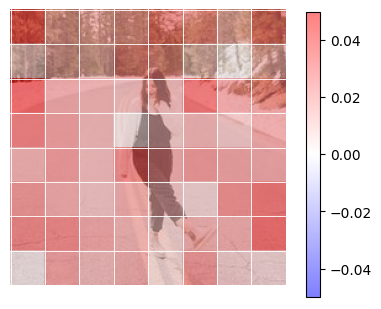

(<Figure size 400x400 with 2 Axes>, <Axes: >)

In [11]:
show_heatmap_with_grid(pil_img, heat, show_colorbar = True)

In [31]:
show_heatmap_with_grid(pil_img, heat, show_colorbar = True, save_path = "D:/figures/binary_high_correct.png")

(<Figure size 400x400 with 2 Axes>, <Axes: >)

In [12]:
# top-k patch indices by delta
k = 5
flat_idx = np.argsort(heat.ravel())[::-1][:k]
coords = [(idx // heat.shape[1], idx % heat.shape[1]) for idx in flat_idx]
vals = [heat[i,j] for i,j in coords]
print("Top patches (row,col) and deltas:", list(zip(coords, vals)))

Top patches (row,col) and deltas: [((np.int64(2), np.int64(0)), np.float32(0.04982984)), ((np.int64(6), np.int64(7)), np.float32(0.045586348)), ((np.int64(2), np.int64(5)), np.float32(0.044221163)), ((np.int64(0), np.int64(0)), np.float32(0.04328382)), ((np.int64(5), np.int64(7)), np.float32(0.04259032))]


In [13]:
# Without text
p_full = predict_proba_from_pil_and_text(pil_img, caption, meta_vec, booster, 2)[1]
p_no_text = predict_proba_from_pil_and_text(pil_img, "", meta_vec, booster, 2)[1]
delta_text = p_full - p_no_text
print("P(high) full:", p_full, "no_text:", p_no_text, "delta_text:", delta_text)

P(high) full: 0.8670936 no_text: 0.8553136 delta_text: 0.011780024


In [14]:
# Without image 

def make_gray_image_like(pil_img, fill=128):
    w, h = pil_img.size
    return Image.new("RGB", (w, h), (fill, fill, fill))

img_gray = make_gray_image_like(pil_img, fill=128)

p_no_img = predict_proba_from_pil_and_text(img_gray, caption, meta_vec, booster, 2)[1]
delta_img = p_full - p_no_img
print("P(high) full:", p_full, "no_img:", p_no_img, "delta_img:", delta_img)


P(high) full: 0.8670936 no_img: 0.52642006 delta_img: 0.34067357


In [15]:
# Without meta
meta_zero = np.zeros_like(meta_vec, dtype=np.float32)
p_no_meta = predict_proba_from_pil_and_text(pil_img, caption, meta_zero, booster, 2)[1]
delta_meta = p_full - p_no_meta
print("P(high) full:", p_full, "no_meta:", p_no_meta, "delta_meta:", delta_meta)

P(high) full: 0.8670936 no_meta: 0.5794145 delta_meta: 0.28767914


In [16]:
# TEXT
idx = 8
row = sample_df.iloc[idx]

pid = row["post_id"]
caption = row["caption"]
img_path = row["img_path_full"]
pil_img = Image.open(img_path).convert("RGB")
meta_vec = row[meta_cols].to_numpy(dtype=np.float32)

tokens, deltas, p_ref_vec, class_idx = text_loo_explain_general(
    pil_img, caption, meta_vec, booster, num_class=2, max_tokens=40, class_idx = 1
)
print("p_ref:", p_ref_vec, "pred:", class_idx)

p_ref: [0.13290638 0.8670936 ] pred: 1


In [17]:
print("p_ref (P(high)):", p_ref_vec)
print("caption:", caption[:200])
print("p_ref:", p_ref_vec)
print("delta min/max:", deltas.min(), deltas.max())

topk = 10
idx_sorted = np.argsort(-np.abs(deltas))  

for k in range(min(topk, len(tokens))):
    i = idx_sorted[k]
    print(f"{k+1:02d}. token='{tokens[i]}'  delta={deltas[i]:+.4f}")

p_ref (P(high)): [0.13290638 0.8670936 ]
caption: Stepping 2019 like see ya 2018 Anyone else ready new year
p_ref: [0.13290638 0.8670936 ]
delta min/max: -0.004225731 0.0071293116
01. token='2019'  delta=+0.0071
02. token='see'  delta=+0.0053
03. token='2018'  delta=+0.0053
04. token='ready'  delta=-0.0042
05. token='like'  delta=+0.0036
06. token='ya'  delta=+0.0036
07. token='else'  delta=+0.0032
08. token='Anyone'  delta=+0.0029
09. token='new'  delta=-0.0027
10. token='Stepping'  delta=+0.0020


In [18]:
K = 2
p_ref_vec = predict_proba_from_pil_and_text(pil_img, caption, meta_vec, booster, K)
pred = int(np.argmax(p_ref_vec))

tokens, scores, p_ref_vec2, class_idx = text_span_explain_general(
    pil_img, caption, meta_vec, booster,
    num_class=K, L=5, max_tokens=60, class_idx=None 
)

print("p_ref (P(high)):", p_ref_vec)
print("caption:", caption[:200])
print("p_ref:", p_ref_vec)
print("score min/max:", scores.min(), scores.max())

topk = 10
idx_sorted = np.argsort(-np.abs(scores)) 

for k in range(min(topk, len(tokens))):
    i = idx_sorted[k]
    print(f"{k+1:02d}. token='{tokens[i]}'  score={scores[i]:+.4f}")


p_ref (P(high)): [0.13290638 0.8670936 ]
caption: Stepping 2019 like see ya 2018 Anyone else ready new year
p_ref: [0.13290638 0.8670936 ]
score min/max: -0.005261719226837158 0.01070287823677063
01. token='2019'  score=+0.0107
02. token='see'  score=+0.0098
03. token='like'  score=+0.0097
04. token='ya'  score=+0.0084
05. token='2018'  score=+0.0081
06. token='year'  score=-0.0053
07. token='new'  score=-0.0030
08. token='Anyone'  score=+0.0029
09. token='else'  score=+0.0017
10. token='ready'  score=-0.0011


In [19]:
# HIGH WRONG (CONFIDENCE 0.22) IMG
idx = 7
row = sample_df.iloc[idx]

pid = row["post_id"]
caption = row["caption"]
img_path = row["img_path_full"]
pil_img = Image.open(img_path).convert("RGB")
meta_vec = row[meta_cols].to_numpy(dtype=np.float32)

p_ref_vec, class_idx, heat = image_occlusion_explain_general(
    caption=caption,
    pil_img=pil_img,
    meta_vec=meta_vec,
    booster=booster,
    num_class=2,
    grid=8,
    class_idx=1
)
print("p_ref:", p_ref_vec, "heat min/max:", heat.min(), heat.max())

p_ref: [0.773668 0.226332] heat min/max: -0.095450565 0.05843249


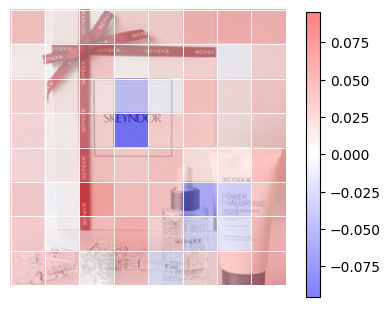

(<Figure size 400x400 with 2 Axes>, <Axes: >)

In [20]:
show_heatmap_with_grid(pil_img, heat, show_colorbar = True)

In [35]:
show_heatmap_with_grid(pil_img, heat, show_colorbar = True, save_path = "D:/figures/binary_high_wrong.png")

(<Figure size 400x400 with 2 Axes>, <Axes: >)

In [21]:
# top-k patch indices by delta
k = 5
flat_idx = np.argsort(heat.ravel())[::-1][:k]
coords = [(idx // heat.shape[1], idx % heat.shape[1]) for idx in flat_idx]
vals = [heat[i,j] for i,j in coords]
print("Top POS patches (row,col) and deltas:", list(zip(coords, vals)))

Top POS patches (row,col) and deltas: [((np.int64(5), np.int64(2)), np.float32(0.05843249)), ((np.int64(6), np.int64(3)), np.float32(0.05016893)), ((np.int64(0), np.int64(6)), np.float32(0.04882954)), ((np.int64(0), np.int64(5)), np.float32(0.04464023)), ((np.int64(7), np.int64(7)), np.float32(0.04454784))]


In [22]:
flat = heat.ravel()
idx_neg = np.argsort(flat)[:5] 
coords_neg = [(i // heat.shape[1], i % heat.shape[1]) for i in idx_neg]
vals_neg = [flat[i] for i in idx_neg]
print("Top NEG patches (row,col) and deltas:", list(zip(coords_neg, vals_neg)))

Top NEG patches (row,col) and deltas: [((np.int64(3), np.int64(3)), np.float32(-0.095450565)), ((np.int64(5), np.int64(5)), np.float32(-0.05540295)), ((np.int64(2), np.int64(3)), np.float32(-0.038663194)), ((np.int64(5), np.int64(6)), np.float32(-0.031711087)), ((np.int64(6), np.int64(5)), np.float32(-0.021185309))]


In [23]:
# Without text
p_full = predict_proba_from_pil_and_text(pil_img, caption, meta_vec, booster, 2)[1]
p_no_text = predict_proba_from_pil_and_text(pil_img, "", meta_vec, booster, 2)[1]
delta_text = p_full - p_no_text
print("P(high) full:", p_full, "no_text:", p_no_text, "delta_text:", delta_text)

P(high) full: 0.226332 no_text: 0.21706381 delta_text: 0.00926818


In [24]:
# Without image 

def make_gray_image_like(pil_img, fill=128):
    w, h = pil_img.size
    return Image.new("RGB", (w, h), (fill, fill, fill))

img_gray = make_gray_image_like(pil_img, fill=128)

p_no_img = predict_proba_from_pil_and_text(img_gray, caption, meta_vec, booster, 2)[1]
delta_img = p_full - p_no_img
print("P(high) full:", p_full, "no_img:", p_no_img, "delta_img:", delta_img)


P(high) full: 0.226332 no_img: 0.32473424 delta_img: -0.09840225


In [25]:
# Without meta
meta_zero = np.zeros_like(meta_vec, dtype=np.float32)
p_no_meta = predict_proba_from_pil_and_text(pil_img, caption, meta_zero, booster, 2)[1]
delta_meta = p_full - p_no_meta
print("P(high) full:", p_full, "no_meta:", p_no_meta, "delta_meta:", delta_meta)

P(high) full: 0.226332 no_meta: 0.19790088 delta_meta: 0.028431118


In [26]:
# HIGH WRONG TEXT
idx = 7
row = sample_df.iloc[idx]

pid = row["post_id"]
caption = row["caption"]
img_path = row["img_path_full"]
pil_img = Image.open(img_path).convert("RGB")
meta_vec = row[meta_cols].to_numpy(dtype=np.float32)

tokens, deltas, p_ref_vec, class_idx = text_loo_explain_general(
    pil_img, caption, meta_vec, booster, num_class=2, max_tokens=40, class_idx = 1
)
print("p_ref:", p_ref_vec, "pred:", class_idx)

p_ref: [0.76236427 0.2376357 ] pred: 1


In [27]:
print("p_ref (P(high)):", p_ref_vec)
print("caption:", caption[:200])
print("p_ref:", p_ref_vec)
print("delta min/max:", deltas.min(), deltas.max())

topk = 10
idx_sorted = np.argsort(-np.abs(deltas))  

for k in range(min(topk, len(tokens))):
    i = idx_sorted[k]
    print(f"{k+1:02d}. token='{tokens[i]}'  delta={deltas[i]:+.4f}")

p_ref (P(high)): [0.76236427 0.2376357 ]
caption: GIVEAWAY SKEYNDOR GREECE Winner 1 Power Hyaluronic Christmas Kit 85 1 Power Hyaluronic Cream 50 ml 2 Booster Power Hyaluronic 30 ml 3 UNIQCURE Peeling Concentrates 7 x 2 ml 3 Like Follow Tag 1 tag MIA
p_ref: [0.76236427 0.2376357 ]
delta min/max: -0.004363045 0.036738098
01. token='GREECE'  delta=+0.0367
02. token='MIA'  delta=+0.0283
03. token='unfollow'  delta=+0.0243
04. token='Cream'  delta=+0.0218
05. token='3'  delta=+0.0201
06. token='3'  delta=+0.0180
07. token='Winner'  delta=+0.0175
08. token='ml'  delta=+0.0175
09. token='tag'  delta=+0.0173
10. token='30'  delta=+0.0172


In [28]:
K = 2
p_ref_vec = predict_proba_from_pil_and_text(pil_img, caption, meta_vec, booster, K)
pred = int(np.argmax(p_ref_vec))

tokens, scores, p_ref_vec2, class_idx = text_span_explain_general(
    pil_img, caption, meta_vec, booster,
    num_class=K, L=5, max_tokens=60, class_idx=1 
)

print("p_ref (P(high)):", p_ref_vec)
print("caption:", caption[:200])
print("p_ref:", p_ref_vec)
print("score min/max:", scores.min(), scores.max())

topk = 10
idx_sorted = np.argsort(-np.abs(scores))  

for k in range(min(topk, len(tokens))):
    i = idx_sorted[k]
    print(f"{k+1:02d}. token='{tokens[i]}'  score={scores[i]:+.4f}")


p_ref (P(high)): [0.773668 0.226332]
caption: GIVEAWAY SKEYNDOR GREECE Winner 1 Power Hyaluronic Christmas Kit 85 1 Power Hyaluronic Cream 50 ml 2 Booster Power Hyaluronic 30 ml 3 UNIQCURE Peeling Concentrates 7 x 2 ml 3 Like Follow Tag 1 tag MIA
p_ref: [0.773668 0.226332]
score min/max: -0.024515017867088318 0.014748916029930115
01. token='GIVEAWAY'  score=-0.0245
02. token='Christmas'  score=-0.0186
03. token='SKEYNDOR'  score=-0.0176
04. token='UNIQCURE'  score=+0.0147
05. token='85'  score=-0.0130
06. token='Kit'  score=-0.0128
07. token='Peeling'  score=+0.0120
08. token='3'  score=+0.0118
09. token='Tag'  score=+0.0097
10. token='Concentrates'  score=+0.0092


In [29]:
# LOW CORRECT (CONFIDENCE 0.89) IMG
idx = 38
row = sample_df.iloc[idx]

pid = row["post_id"]
caption = row["caption"]
img_path = row["img_path_full"]
pil_img = Image.open(img_path).convert("RGB")
meta_vec = row[meta_cols].to_numpy(dtype=np.float32)

p_ref_vec, class_idx, heat = image_occlusion_explain_general(
    caption=caption,
    pil_img=pil_img,
    meta_vec=meta_vec,
    booster=booster,
    num_class=2,
    grid=8,
    class_idx=1
)
print("p_ref:", p_ref_vec, "heat min/max:", heat.min(), heat.max())

p_ref: [0.8901085  0.10989145] heat min/max: -0.043022655 0.007931918


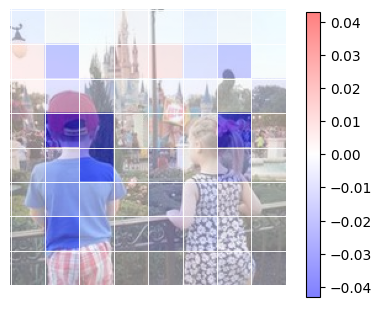

(<Figure size 400x400 with 2 Axes>, <Axes: >)

In [30]:
show_heatmap_with_grid(pil_img, heat, show_colorbar = True)

In [37]:
show_heatmap_with_grid(pil_img, heat, show_colorbar = True, save_path = "D:/figures/binary_low_correct.png")

(<Figure size 400x400 with 2 Axes>, <Axes: >)

In [31]:
# top-k patch indices by delta
k = 5
flat_idx = np.argsort(heat.ravel())[::-1][:k]
coords = [(idx // heat.shape[1], idx % heat.shape[1]) for idx in flat_idx]
vals = [heat[i,j] for i,j in coords]
print("Top POS patches (row,col) and deltas:", list(zip(coords, vals)))

flat = heat.ravel()
idx_neg = np.argsort(flat)[:5]  # più negative
coords_neg = [(i // heat.shape[1], i % heat.shape[1]) for i in idx_neg]
vals_neg = [flat[i] for i in idx_neg]
print("Top NEG patches (row,col) and deltas:", list(zip(coords_neg, vals_neg)))

Top POS patches (row,col) and deltas: [((np.int64(1), np.int64(4)), np.float32(0.007931918)), ((np.int64(1), np.int64(3)), np.float32(0.0065982044)), ((np.int64(1), np.int64(0)), np.float32(0.0058115274)), ((np.int64(3), np.int64(0)), np.float32(0.0038542226)), ((np.int64(2), np.int64(0)), np.float32(0.0037109628))]
Top NEG patches (row,col) and deltas: [((np.int64(3), np.int64(1)), np.float32(-0.043022655)), ((np.int64(3), np.int64(6)), np.float32(-0.040953152)), ((np.int64(4), np.int64(2)), np.float32(-0.03405296)), ((np.int64(3), np.int64(2)), np.float32(-0.032312907)), ((np.int64(6), np.int64(1)), np.float32(-0.024807133))]


In [35]:
# Without text
p_full = predict_proba_from_pil_and_text(pil_img, caption, meta_vec, booster, 2)[1]
p_no_text = predict_proba_from_pil_and_text(pil_img, "", meta_vec, booster, 2)[1]
delta_text = p_full - p_no_text
print("P(high) full:", p_full, "no_text:", p_no_text, "delta_text:", delta_text)

P(high) full: 0.10989145 no_text: 0.12952302 delta_text: -0.019631572


In [36]:
# Without image 

def make_gray_image_like(pil_img, fill=128):
    w, h = pil_img.size
    return Image.new("RGB", (w, h), (fill, fill, fill))

img_gray = make_gray_image_like(pil_img, fill=128)

p_no_img = predict_proba_from_pil_and_text(img_gray, caption, meta_vec, booster, 2)[1]
delta_img = p_full - p_no_img
print("P(high) full:", p_full, "no_img:", p_no_img, "delta_img:", delta_img)


P(high) full: 0.10989145 no_img: 0.06252577 delta_img: 0.04736568


In [37]:
# Without meta
meta_zero = np.zeros_like(meta_vec, dtype=np.float32)
p_no_meta = predict_proba_from_pil_and_text(pil_img, caption, meta_zero, booster, 2)[1]
delta_meta = p_full - p_no_meta
print("P(high) full:", p_full, "no_meta:", p_no_meta, "delta_meta:", delta_meta)

P(high) full: 0.10989145 no_meta: 0.39546496 delta_meta: -0.2855735


In [38]:
# LOW CORRECT TEXT
idx = 38
row = sample_df.iloc[idx]

pid = row["post_id"]
caption = row["caption"]
img_path = row["img_path_full"]
pil_img = Image.open(img_path).convert("RGB")
meta_vec = row[meta_cols].to_numpy(dtype=np.float32)

tokens, deltas, p_ref_vec, class_idx = text_loo_explain_general(
    pil_img, caption, meta_vec, booster, num_class=2, max_tokens=40, class_idx = 1
)
print("p_ref:", p_ref_vec, "pred:", class_idx)

p_ref: [0.8901085  0.10989145] pred: 1


In [39]:
print("p_ref (P(high)):", p_ref_vec)
print("caption:", caption[:200])
print("p_ref:", p_ref_vec)
print("delta min/max:", deltas.min(), deltas.max())

topk = 10
idx_sorted = np.argsort(-np.abs(deltas))  

for k in range(min(topk, len(tokens))):
    i = idx_sorted[k]
    print(f"{k+1:02d}. token='{tokens[i]}'  delta={deltas[i]:+.4f}")

p_ref (P(high)): [0.8901085  0.10989145]
caption: much longer view year half since last got news offer accepted house much changed since last trip busy projects come along owning new home missing place coming home soon Disney Mom Disney Kids waltdisn
p_ref: [0.8901085  0.10989145]
delta min/max: -0.004649833 0.0042873025
01. token='half'  delta=-0.0046
02. token='offer'  delta=+0.0043
03. token='much'  delta=-0.0040
04. token='view'  delta=-0.0039
05. token='come'  delta=+0.0034
06. token='waltdisneyworld'  delta=+0.0029
07. token='Mom'  delta=+0.0025
08. token='year'  delta=+0.0025
09. token='new'  delta=-0.0024
10. token='owning'  delta=+0.0019


In [40]:
K = 2
p_ref_vec = predict_proba_from_pil_and_text(pil_img, caption, meta_vec, booster, K)
pred = int(np.argmax(p_ref_vec))

tokens, scores, p_ref_vec2, class_idx = text_span_explain_general(
    pil_img, caption, meta_vec, booster,
    num_class=K, L=5, max_tokens=60, class_idx=1 
)

print("p_ref (P(high)):", p_ref_vec)
print("caption:", caption[:200])
print("p_ref:", p_ref_vec)
print("score min/max:", scores.min(), scores.max())

topk = 10
idx_sorted = np.argsort(-np.abs(scores))  

for k in range(min(topk, len(tokens))):
    i = idx_sorted[k]
    print(f"{k+1:02d}. token='{tokens[i]}'  score={scores[i]:+.4f}")


p_ref (P(high)): [0.8901085  0.10989145]
caption: much longer view year half since last got news offer accepted house much changed since last trip busy projects come along owning new home missing place coming home soon Disney Mom Disney Kids waltdisn
p_ref: [0.8901085  0.10989145]
score min/max: -0.0025182098150253298 0.01746489852666855
01. token='waltdisneyworld'  score=+0.0175
02. token='Kids'  score=+0.0130
03. token='Disney'  score=+0.0115
04. token='Mom'  score=+0.0106
05. token='Disney'  score=+0.0093
06. token='soon'  score=+0.0074
07. token='home'  score=+0.0073
08. token='coming'  score=+0.0064
09. token='much'  score=+0.0057
10. token='place'  score=+0.0048


In [41]:
# LOW WRONG (CONFIDENCE 0.77 HIGH) IMG
idx = 33
row = sample_df.iloc[idx]

pid = row["post_id"]
caption = row["caption"]
img_path = row["img_path_full"]
pil_img = Image.open(img_path).convert("RGB")
meta_vec = row[meta_cols].to_numpy(dtype=np.float32)

p_ref_vec, class_idx, heat = image_occlusion_explain_general(
    caption=caption,
    pil_img=pil_img,
    meta_vec=meta_vec,
    booster=booster,
    num_class=2,
    grid=8,
    class_idx=1
)
print("p_ref:", p_ref_vec, "heat min/max:", heat.min(), heat.max()) 

p_ref: [0.3400895 0.6599105] heat min/max: -0.043815553 0.08510679


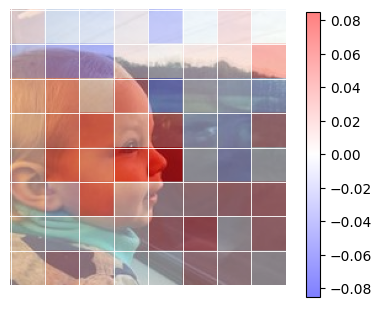

(<Figure size 400x400 with 2 Axes>, <Axes: >)

In [42]:
show_heatmap_with_grid(pil_img, heat, show_colorbar = True)

In [39]:
show_heatmap_with_grid(pil_img, heat, show_colorbar = True, save_path = "D:/figures/binary_low_wrong.png")

(<Figure size 400x400 with 2 Axes>, <Axes: >)

In [43]:
# top-k patch indices by delta
k = 5
flat_idx = np.argsort(heat.ravel())[::-1][:k]
coords = [(idx // heat.shape[1], idx % heat.shape[1]) for idx in flat_idx]
vals = [heat[i,j] for i,j in coords]
print("Top POS patches (row,col) and deltas:", list(zip(coords, vals)))

flat = heat.ravel()
idx_neg = np.argsort(flat)[:5]  
coords_neg = [(i // heat.shape[1], i % heat.shape[1]) for i in idx_neg]
vals_neg = [flat[i] for i in idx_neg]
print("Top NEG patches (row,col) and deltas:", list(zip(coords_neg, vals_neg)))

Top POS patches (row,col) and deltas: [((np.int64(4), np.int64(4)), np.float32(0.08510679)), ((np.int64(4), np.int64(3)), np.float32(0.07374191)), ((np.int64(3), np.int64(4)), np.float32(0.05390483)), ((np.int64(6), np.int64(5)), np.float32(0.053155124)), ((np.int64(3), np.int64(2)), np.float32(0.049496233))]
Top NEG patches (row,col) and deltas: [((np.int64(1), np.int64(2)), np.float32(-0.043815553)), ((np.int64(1), np.int64(1)), np.float32(-0.041514695)), ((np.int64(2), np.int64(4)), np.float32(-0.03400266)), ((np.int64(0), np.int64(4)), np.float32(-0.02871567)), ((np.int64(1), np.int64(0)), np.float32(-0.027201056))]


In [44]:
# Without text
p_full = predict_proba_from_pil_and_text(pil_img, caption, meta_vec, booster, 2)[1]
p_no_text = predict_proba_from_pil_and_text(pil_img, "", meta_vec, booster, 2)[1]
delta_text = p_full - p_no_text
print("P(high) full:", p_full, "no_text:", p_no_text, "delta_text:", delta_text)

P(high) full: 0.6599105 no_text: 0.64441884 delta_text: 0.015491664


In [45]:
# Without image 

def make_gray_image_like(pil_img, fill=128):
    w, h = pil_img.size
    return Image.new("RGB", (w, h), (fill, fill, fill))

img_gray = make_gray_image_like(pil_img, fill=128)

p_no_img = predict_proba_from_pil_and_text(img_gray, caption, meta_vec, booster, 2)[1]
delta_img = p_full - p_no_img
print("P(high) full:", p_full, "no_img:", p_no_img, "delta_img:", delta_img)


P(high) full: 0.6599105 no_img: 0.26208407 delta_img: 0.39782643


In [46]:
# Without meta
meta_zero = np.zeros_like(meta_vec, dtype=np.float32)
p_no_meta = predict_proba_from_pil_and_text(pil_img, caption, meta_zero, booster, 2)[1]
delta_meta = p_full - p_no_meta
print("P(high) full:", p_full, "no_meta:", p_no_meta, "delta_meta:", delta_meta)

P(high) full: 0.6599105 no_meta: 0.49998313 delta_meta: 0.15992737


In [47]:
# LOW WRONG
idx = 33
row = sample_df.iloc[idx]

pid = row["post_id"]
caption = row["caption"]
img_path = row["img_path_full"]
pil_img = Image.open(img_path).convert("RGB")
meta_vec = row[meta_cols].to_numpy(dtype=np.float32)

tokens, deltas, p_ref_vec, class_idx = text_loo_explain_general(
    pil_img, caption, meta_vec, booster, num_class=2, max_tokens=40, class_idx = 1
)
print("p_ref:", p_ref_vec, "pred:", class_idx)

p_ref: [0.3400895 0.6599105] pred: 1


In [48]:
print("p_ref (P(high)):", p_ref_vec)
print("caption:", caption[:200])
print("p_ref:", p_ref_vec)
print("delta min/max:", deltas.min(), deltas.max())

topk = 10
idx_sorted = np.argsort(-np.abs(deltas))  

for k in range(min(topk, len(tokens))):
    i = idx_sorted[k]
    print(f"{k+1:02d}. token='{tokens[i]}'  delta={deltas[i]:+.4f}")

p_ref (P(high)): [0.3400895 0.6599105]
caption: early watching sun rise train London exciting Charlie x
p_ref: [0.3400895 0.6599105]
delta min/max: -0.002676487 0.075202584
01. token='watching'  delta=+0.0752
02. token='rise'  delta=+0.0671
03. token='sun'  delta=+0.0565
04. token='x'  delta=+0.0313
05. token='Charlie'  delta=+0.0298
06. token='London'  delta=+0.0124
07. token='early'  delta=+0.0078
08. token='train'  delta=+0.0073
09. token='exciting'  delta=-0.0027


In [49]:
K = 2
p_ref_vec = predict_proba_from_pil_and_text(pil_img, caption, meta_vec, booster, K)
pred = int(np.argmax(p_ref_vec))

tokens, scores, p_ref_vec2, class_idx = text_span_explain_general(
    pil_img, caption, meta_vec, booster,
    num_class=K, L=5, max_tokens=60, class_idx=1  
)

print("p_ref (P(high)):", p_ref_vec)
print("caption:", caption[:200])
print("p_ref:", p_ref_vec)
print("score min/max:", scores.min(), scores.max())

topk = 10
idx_sorted = np.argsort(-np.abs(scores)) 

for k in range(min(topk, len(tokens))):
    i = idx_sorted[k]
    print(f"{k+1:02d}. token='{tokens[i]}'  score={scores[i]:+.4f}")


p_ref (P(high)): [0.3400895 0.6599105]
caption: early watching sun rise train London exciting Charlie x
p_ref: [0.3400895 0.6599105]
score min/max: 0.0237157940864563 0.10659784078598022
01. token='early'  score=+0.1066
02. token='watching'  score=+0.0629
03. token='sun'  score=+0.0547
04. token='rise'  score=+0.0524
05. token='train'  score=+0.0467
06. token='exciting'  score=+0.0359
07. token='Charlie'  score=+0.0346
08. token='London'  score=+0.0317
09. token='x'  score=+0.0237


# 3 CLASSI

## Define sample

In [68]:
X_tr = np.load("D:/dataset/multimodal3/X_tr.npy", allow_pickle = True).astype(np.float32)
X_te = np.load("D:/dataset/multimodal3/X_te.npy", allow_pickle = True).astype(np.float32)

y_tr = np.load("D:/dataset/multimodal3/y_tr_3.npy", allow_pickle = True)
y_te = np.load("D:/dataset/multimodal3/y_te_3.npy", allow_pickle = True)

le = LabelEncoder()
y_tr_enc = le.fit_transform(y_tr)
y_te_enc = le.transform(y_te)

for i, cls in enumerate(le.classes_):
    print(i, "->", cls)

0 -> high
1 -> low
2 -> medium


In [40]:
# Load XGBoost booster
booster = xgb.Booster()
booster.load_model(r"D:/dataset/explainability/xgb_clip_3.json")

In [41]:
# Define the candidate posts with one image

DB_PATH = "D:/db/meta.duckdb"
con = duckdb.connect(DB_PATH)

one_img_df = con.sql("""
WITH one_img AS (
  SELECT
    post_id,
    MIN(full_image_file) AS img_path
  FROM images_manifest1718
  GROUP BY post_id
  HAVING COUNT(*) = 1
)
SELECT
  m.post_id,
  m.caption_bert_clip AS caption,
  m.er_bins3 AS y_true,
  o.img_path
FROM md1718 m
JOIN one_img o USING (post_id)
WHERE m.split = 'test'
""").df()

one_img_df.head(), one_img_df.shape

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

(                               post_id  \
 0  collinrossfilms-1928431121747229677   
 1  collinrossfilms-1931729185157238739   
 2  collinrossfilms-1937878799686061326   
 3  collinrossfilms-1939584671181332811   
 4  colliveofficial-1941535137632413406   
 
                                              caption  y_true  \
 0                                      Fort Worth TX    high   
 1                                                       high   
 2                                                     medium   
 3                                                       high   
 4  REBBE NITTEL NACHT Lubavitcher Rebbe Previous ...    high   
 
                                   img_path  
 0  collinrossfilms-1928431121747229677.jpg  
 1  collinrossfilms-1931729185157238739.jpg  
 2  collinrossfilms-1937878799686061326.jpg  
 3  collinrossfilms-1939584671181332811.jpg  
 4  colliveofficial-1941535137632413406.jpg  ,
 (356979, 4))

In [42]:
# Define the sample, with x number of posts per class
sample_df = stratified_sample(one_img_df, "y_true", n_per_class=20, seed=42)
sample_df["y_true"].value_counts(), sample_df.shape

C:\Users\mimox\AppData\Local\Temp\ipykernel_18260\4151775902.py:18: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(min(n_per_class, len(g)), random_state=seed))


(y_true
 high      20
 low       20
 medium    20
 Name: count, dtype: int64,
 (60, 4))

In [43]:
# Reconstruct the image path

IMG_ROOT = "D:/dataset/images_224_rgb"
sample_df = sample_df.copy()
sample_df["img_path_full"] = sample_df["img_path"].apply(lambda x: os.path.join(IMG_ROOT, x))
sample_df

,post_id,caption,y_true,img_path,img_path_full
0,dear.lorrie-1932321739186950927,Food favourite subject know eat good food talk...,high,dear.lorrie-1932321739186950927.jpg,D:/dataset/images_224_rgb\dear.lorrie-19323217...
1,deborah_arizmendi-1928530164170561311,Memorias de un amor en que moría por ti tu te ...,high,deborah_arizmendi-1928530164170561311.jpg,D:/dataset/images_224_rgb\deborah_arizmendi-19...
2,isuspectnargles-1929928878395190738,12daysofpotterchristmas Day 8 Common Room plan...,high,isuspectnargles-1929928878395190738.jpg,D:/dataset/images_224_rgb\isuspectnargles-1929...
3,bluebird_cosplay-1941387007138464883,Space filler beautiful boy cat kitty christmas,high,bluebird_cosplay-1941387007138464883.jpg,D:/dataset/images_224_rgb\bluebird_cosplay-194...
4,hunterharden-1941545969993467692,Waiting Santa Stuff Stocking Tonite wink wink ...,high,hunterharden-1941545969993467692.jpg,D:/dataset/images_224_rgb\hunterharden-1941545...
5,inthesejeans-1933736456703114428,Joy Lab keeping warm cozy coldest days ad,high,inthesejeans-1933736456703114428.jpg,D:/dataset/images_224_rgb\inthesejeans-1933736...
6,2lives1camera-1943664939102570890,Let take look back 9 posts guys liked engaged ...,high,2lives1camera-1943664939102570890.jpg,D:/dataset/images_224_rgb\2lives1camera-194366...
7,countingstars-1934928782171673923,miyajima japan instatravel travelblog instapic...,high,countingstars-1934928782171673923.jpg,D:/dataset/images_224_rgb\countingstars-193492...
8,mariajialingpitt-1938166967059956579,making magic like used play sims making magic ...,high,mariajialingpitt-1938166967059956579.jpg,D:/dataset/images_224_rgb\mariajialingpitt-193...
9,yasminevans-1933346025377259642,SUGABABES daytime entertainment,high,yasminevans-1933346025377259642.jpg,D:/dataset/images_224_rgb\yasminevans-19333460...


In [44]:
meta_final = pd.read_csv(r"D:/dataset/meta_classification/meta_test_final.csv")
sample_df = sample_df.merge(meta_final, on="post_id", how="left")
# Check there are no missing values
missing = sample_df[sample_df.isna().any(axis=1)]
print("Righe con NaN dopo merge:", len(missing))
missing[["post_id"]].head()

Righe con NaN dopo merge: 0


,post_id


In [45]:
K = 3
p_refs = []

for _, row in sample_df.iterrows():
    meta_vec = row[meta_cols].to_numpy(dtype=np.float32)

    p = predict_proba(
        caption=row["caption"],
        img_path=row["img_path_full"],
        meta_vec=meta_vec,
        booster=booster,
        num_class=K
    )  
    p_refs.append(p)

p_mat = np.vstack(p_refs) 

sample_df = sample_df.copy()
sample_df["p0"] = p_mat[:, 0]
sample_df["p1"] = p_mat[:, 1]
sample_df["p2"] = p_mat[:, 2]

In [46]:
sample_df["y_pred"] = np.argmax(p_mat, axis=1).astype(int)

if np.issubdtype(sample_df["y_true"].dtype, np.number):
    sample_df["y_true_enc"] = sample_df["y_true"].astype(int)

else:
    map_3 = {
        "high": 0,
        "low": 1,
        "medium": 2
    }
    sample_df["y_true_enc"] = sample_df["y_true"].map(map_3)

    if sample_df["y_true_enc"].isna().any():
        bad = sample_df.loc[sample_df["y_true_enc"].isna(), "y_true"].unique()
        raise ValueError(f"Unmapped y_true labels: {bad}. Aggiorna map_3.")

    sample_df["y_true_enc"] = sample_df["y_true_enc"].astype(int)

sample_df["correct"] = (sample_df["y_pred"] == sample_df["y_true_enc"])

print(sample_df["correct"].value_counts())
print("sample accuracy:", sample_df["correct"].mean())

inv_map_3 = {0:"high", 1:"low", 2:"medium"}
sample_df["y_pred_label"] = sample_df["y_pred"].map(inv_map_3)

correct
True     32
False    28
Name: count, dtype: int64
sample accuracy: 0.5333333333333333


In [49]:
sample_df[['p0', 'p1', 'p2', "y_true", "correct", "y_pred_label"]]

,p0,p1,p2,y_true,correct,y_pred_label
0,0.525972,0.182305,0.291722,high,True,high
1,0.215206,0.345814,0.438980,high,False,medium
2,0.260527,0.338975,0.400498,high,False,medium
3,0.682619,0.141472,0.175909,high,True,high
4,0.359088,0.229951,0.410961,high,False,medium
5,0.482014,0.162561,0.355426,high,True,high
6,0.839595,0.036844,0.123562,high,True,high
7,0.164756,0.542544,0.292700,high,False,low
8,0.274247,0.326654,0.399099,high,False,medium
9,0.477172,0.211999,0.310828,high,True,high


In [48]:
sample_df.to_csv(
    "D:/dataset/explainability/sample_for_local_explainability_3.csv",
    index=False
)

In [ ]:
sample_df = pd.read_csv("D:/dataset/explainability/sample_for_local_explainability_3.csv")

## Local explanations

In [9]:
sample_df = pd.read_csv("D:/dataset/explainability/sample_for_local_explainability_3.csv")
base_cols = ["post_id", "caption", "img_path", "img_path_full", "y_true", "p0", "p1", "p2", "y_true_enc", "y_pred"]

# Select numeric columns
meta_cols = sample_df.drop(columns=base_cols, errors="ignore").select_dtypes(include=[np.number]).columns.tolist()
print("n_meta_cols:", len(meta_cols))
print(meta_cols)
# Load XGBoost booster
booster = xgb.Booster()
booster.load_model(r"D:/dataset/explainability/xgb_clip_3.json")

n_meta_cols: 28
['width', 'height', 'aspect_ratio', 'area', 'dow', 'hour_utc', 'month', 'year', 'caption_len_char', 'n_hashtags', 'n_mentions', 'n_urls', 'n_emojis', 'followees', 'posts', 'has_caption', 'orientation_landscape', 'orientation_portrait', 'orientation_square', 'category_beauty', 'category_family', 'category_fashion', 'category_fitness', 'category_food', 'category_interior', 'category_other', 'category_pet', 'category_travel']


In [10]:
# HIGH CORRECT
idx = 17
row = sample_df.iloc[idx]

pid = row["post_id"]
caption = row["caption"]
img_path = row["img_path_full"]
pil_img = Image.open(img_path).convert("RGB")
meta_vec = row[meta_cols].to_numpy(dtype=np.float32)

p_ref_vec, class_idx, heat = image_occlusion_explain_general(
    caption=caption,
    pil_img=pil_img,
    meta_vec=meta_vec,
    booster=booster,
    num_class=3,
    grid=8)
print("p_ref:", p_ref_vec, "pred:", class_idx, "heat min/max:", heat.min(), heat.max())

p_ref: [0.8079878  0.04825765 0.14375454] pred: 0 heat min/max: -0.028553843 0.099328816


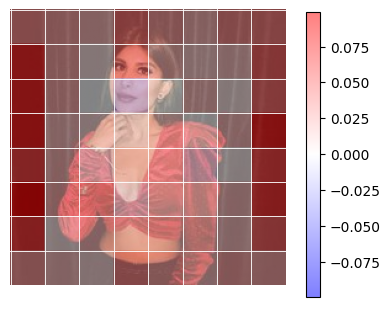

(<Figure size 400x400 with 2 Axes>, <Axes: >)

In [166]:
show_heatmap_with_grid(pil_img, heat, show_colorbar = True)

In [11]:
show_heatmap_with_grid(pil_img, heat, show_colorbar = True, save_path = "D:/figures/3_high_correct.png")

(<Figure size 400x400 with 2 Axes>, <Axes: >)

In [167]:
tokens, deltas, p_ref_vec, class_idx = text_loo_explain_general(
    pil_img, caption, meta_vec, booster, num_class=3, max_tokens=40
)
print("p_ref:", p_ref_vec, "pred:", class_idx)

p_ref: [0.8079878  0.04825765 0.14375454] pred: 0


In [168]:
print("p_ref (P(high)):", p_ref_vec)
print("caption:", caption[:200])
print("p_ref:", p_ref_vec)
print("delta min/max:", deltas.min(), deltas.max())

topk = 10
idx_sorted = np.argsort(-np.abs(deltas)) 

for k in range(min(topk, len(tokens))):
    i = idx_sorted[k]
    print(f"{k+1:02d}. token='{tokens[i]}'  delta={deltas[i]:+.4f}")

p_ref (P(high)): [0.8079878  0.04825765 0.14375454]
caption: mine wonderful Christmas
p_ref: [0.8079878  0.04825765 0.14375454]
delta min/max: -0.013257861 0.006031871
01. token='mine'  delta=-0.0133
02. token='wonderful'  delta=+0.0060
03. token='Christmas'  delta=-0.0055


In [169]:
K = 3
p_ref_vec = predict_proba_from_pil_and_text(pil_img, caption, meta_vec, booster, K)
pred = int(np.argmax(p_ref_vec))

tokens, scores, p_ref_vec2, class_idx = text_span_explain_general(
    pil_img, caption, meta_vec, booster,
    num_class=K, L=5, max_tokens=60)

print("p_ref (P(high)):", p_ref_vec)
print("caption:", caption[:200])
print("p_ref:", p_ref_vec)
print("score min/max:", scores.min(), scores.max())

topk = 10
idx_sorted = np.argsort(-np.abs(scores)) 

for k in range(min(topk, len(tokens))):
    i = idx_sorted[k]
    print(f"{k+1:02d}. token='{tokens[i]}'  score={scores[i]:+.4f}")


p_ref (P(high)): [0.8079878  0.04825765 0.14375454]
caption: mine wonderful Christmas
p_ref: [0.8079878  0.04825765 0.14375454]
score min/max: 0.0 0.0
01. token='mine'  score=+0.0000
02. token='wonderful'  score=+0.0000
03. token='Christmas'  score=+0.0000


In [170]:
K = 3
out = modality_ablation_predicted_class(pil_img, caption, meta_vec, booster, K)
print(out)

{'class_idx': 0, 'p_full': 0.8079878091812134, 'p_no_text': 0.786532461643219, 'delta_text': 0.021455347537994385, 'p_no_img': 0.5307230353355408, 'delta_img': 0.2772647738456726, 'p_no_meta': 0.40819641947746277, 'delta_meta': 0.3997913897037506, 'p_full_vec': array([0.8079878 , 0.04825765, 0.14375454], dtype=float32)}


In [12]:
# HIGH WRONG
idx = 13
row = sample_df.iloc[idx]

pid = row["post_id"]
caption = row["caption"]
img_path = row["img_path_full"]
pil_img = Image.open(img_path).convert("RGB")
meta_vec = row[meta_cols].to_numpy(dtype=np.float32)

p_ref_vec, class_idx, heat = image_occlusion_explain_general(
    caption=caption,
    pil_img=pil_img,
    meta_vec=meta_vec,
    booster=booster,
    num_class=3,
    grid=8,
)
print("p_ref:", p_ref_vec, "pred:", class_idx, "heat min/max:", heat.min(), heat.max())

p_ref: [0.35582227 0.23684585 0.40733182] pred: 2 heat min/max: -0.014765948 0.06763896


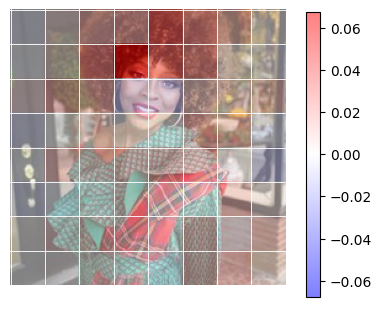

(<Figure size 400x400 with 2 Axes>, <Axes: >)

In [172]:
show_heatmap_with_grid(pil_img, heat, show_colorbar = True)

In [13]:
show_heatmap_with_grid(pil_img, heat, show_colorbar = True, save_path = "D:/figures/3_high_wrong.png")

(<Figure size 400x400 with 2 Axes>, <Axes: >)

In [173]:
tokens, deltas, p_ref_vec, class_idx = text_loo_explain_general(
    pil_img, caption, meta_vec, booster, num_class=3, max_tokens=40
)
print("p_ref:", p_ref_vec, "pred:", class_idx)

p_ref: [0.35062772 0.26998952 0.37938276] pred: 2


In [174]:
print("p_ref (P(high)):", p_ref_vec)
print("caption:", caption[:200])
print("p_ref:", p_ref_vec)
print("delta min/max:", deltas.min(), deltas.max())

topk = 10
idx_sorted = np.argsort(-np.abs(deltas))  

for k in range(min(topk, len(tokens))):
    i = idx_sorted[k]
    print(f"{k+1:02d}. token='{tokens[i]}'  delta={deltas[i]:+.4f}")

p_ref (P(high)): [0.35062772 0.26998952 0.37938276]
caption: nice professional goes long way sharing gems small business bloggers Dont let business Etiquette put naughty list Check IG STORIES Wig CARIB10 10 free shipping wig ponytail Earrings Eyeshadow run SHOR
p_ref: [0.35062772 0.26998952 0.37938276]
delta min/max: -0.011349499 0.017772257
01. token='bloggers'  delta=+0.0178
02. token='CARIB10'  delta=+0.0157
03. token='Dont'  delta=+0.0119
04. token='IG'  delta=+0.0119
05. token='free'  delta=-0.0113
06. token='ponytail'  delta=-0.0111
07. token='Sokoto'  delta=-0.0108
08. token='way'  delta=-0.0093
09. token='cherry'  delta=-0.0085
10. token='palette'  delta=-0.0081


In [175]:
K = 3
p_ref_vec = predict_proba_from_pil_and_text(pil_img, caption, meta_vec, booster, K)
pred = int(np.argmax(p_ref_vec))

tokens, scores, p_ref_vec2, class_idx = text_span_explain_general(
    pil_img, caption, meta_vec, booster,
    num_class=K, L=5, max_tokens=60  
)

print("p_ref (P(high)):", p_ref_vec)
print("caption:", caption[:200])
print("p_ref:", p_ref_vec)
print("score min/max:", scores.min(), scores.max())

topk = 10
idx_sorted = np.argsort(-np.abs(scores))  

for k in range(min(topk, len(tokens))):
    i = idx_sorted[k]
    print(f"{k+1:02d}. token='{tokens[i]}'  score={scores[i]:+.4f}")


p_ref (P(high)): [0.35582227 0.23684585 0.40733182]
caption: nice professional goes long way sharing gems small business bloggers Dont let business Etiquette put naughty list Check IG STORIES Wig CARIB10 10 free shipping wig ponytail Earrings Eyeshadow run SHOR
p_ref: [0.35582227 0.23684585 0.40733182]
score min/max: -0.016245758533477782 0.03521648049354553
01. token='nice'  score=+0.0352
02. token='professional'  score=+0.0194
03. token='business'  score=-0.0162
04. token='Etiquette'  score=-0.0155
05. token='gems'  score=-0.0143
06. token='business'  score=-0.0140
07. token='small'  score=-0.0139
08. token='Dont'  score=-0.0135
09. token='let'  score=-0.0127
10. token='goes'  score=+0.0119


In [176]:
K = 3
out = modality_ablation_predicted_class(pil_img, caption, meta_vec, booster, K)
print(out)

{'class_idx': 2, 'p_full': 0.40733182430267334, 'p_no_text': 0.4015601575374603, 'delta_text': 0.005771666765213013, 'p_no_img': 0.3750728964805603, 'delta_img': 0.03225892782211304, 'p_no_meta': 0.3788681924343109, 'delta_meta': 0.028463631868362427, 'p_full_vec': array([0.35582227, 0.23684585, 0.40733182], dtype=float32)}


In [14]:
# LOW CORRECT
idx = 22
row = sample_df.iloc[idx]

pid = row["post_id"]
caption = row["caption"]
img_path = row["img_path_full"]
pil_img = Image.open(img_path).convert("RGB")
meta_vec = row[meta_cols].to_numpy(dtype=np.float32)

p_ref_vec, class_idx, heat = image_occlusion_explain_general(
    caption=caption,
    pil_img=pil_img,
    meta_vec=meta_vec,
    booster=booster,
    num_class=3,
    grid=8,
)
print("p_ref:", p_ref_vec, "pred:", class_idx, "heat min/max:", heat.min(), heat.max())

p_ref: [0.03557667 0.828472   0.13595136] pred: 1 heat min/max: -0.027031481 0.015248656


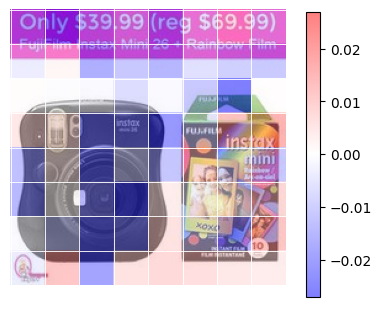

(<Figure size 400x400 with 2 Axes>, <Axes: >)

In [178]:
show_heatmap_with_grid(pil_img, heat, show_colorbar = True)

In [15]:
show_heatmap_with_grid(pil_img, heat, show_colorbar = True, save_path = "D:/figures/3_low_correct.png")

(<Figure size 400x400 with 2 Axes>, <Axes: >)

In [179]:
tokens, deltas, p_ref_vec, class_idx = text_loo_explain_general(
    pil_img, caption, meta_vec, booster, num_class=3, max_tokens=40
)
print("p_ref:", p_ref_vec, "pred:", class_idx)

p_ref: [0.03557667 0.828472   0.13595136] pred: 1


In [180]:
print("p_ref (P(high)):", p_ref_vec)
print("caption:", caption[:200])
print("p_ref:", p_ref_vec)
print("delta min/max:", deltas.min(), deltas.max())

topk = 10
idx_sorted = np.argsort(-np.abs(deltas)) 

for k in range(min(topk, len(tokens))):
    i = idx_sorted[k]
    print(f"{k+1:02d}. token='{tokens[i]}'  delta={deltas[i]:+.4f}")

p_ref (P(high)): [0.03557667 0.828472   0.13595136]
caption: WOW Fuji Film Instacart Mini 26 Film Bundle 39 99 reg 69 99 Click link profile scroll picture hurry sold go Coupon Expert com Tag friend holidayhelper giftidea couponing floridacouponer georgiacoupone
p_ref: [0.03557667 0.828472   0.13595136]
delta min/max: -0.037355304 0.010210156
01. token='Instacart'  delta=-0.0374
02. token='Bundle'  delta=-0.0349
03. token='26'  delta=-0.0334
04. token='Coupon'  delta=-0.0201
05. token='link'  delta=-0.0151
06. token='Fuji'  delta=-0.0132
07. token='Mini'  delta=-0.0107
08. token='floridacouponer'  delta=+0.0102
09. token='Click'  delta=-0.0102
10. token='holidayhelper'  delta=-0.0091


In [181]:
K = 3
p_ref_vec = predict_proba_from_pil_and_text(pil_img, caption, meta_vec, booster, K)
pred = int(np.argmax(p_ref_vec))

tokens, scores, p_ref_vec2, class_idx = text_span_explain_general(
    pil_img, caption, meta_vec, booster,
    num_class=K, L=5, max_tokens=60
)

print("p_ref (P(high)):", p_ref_vec)
print("caption:", caption[:200])
print("p_ref:", p_ref_vec)
print("score min/max:", scores.min(), scores.max())

topk = 10
idx_sorted = np.argsort(-np.abs(scores)) 

for k in range(min(topk, len(tokens))):
    i = idx_sorted[k]
    print(f"{k+1:02d}. token='{tokens[i]}'  score={scores[i]:+.4f}")


p_ref (P(high)): [0.03557667 0.828472   0.13595136]
caption: WOW Fuji Film Instacart Mini 26 Film Bundle 39 99 reg 69 99 Click link profile scroll picture hurry sold go Coupon Expert com Tag friend holidayhelper giftidea couponing floridacouponer georgiacoupone
p_ref: [0.03557667 0.828472   0.13595136]
score min/max: -0.04042594432830811 -0.002270519733428955
01. token='26'  score=-0.0404
02. token='Film'  score=-0.0393
03. token='Mini'  score=-0.0386
04. token='Instacart'  score=-0.0375
05. token='Film'  score=-0.0356
06. token='Bundle'  score=-0.0332
07. token='WOW'  score=-0.0287
08. token='Fuji'  score=-0.0267
09. token='39'  score=-0.0250
10. token='99'  score=-0.0186


In [182]:
K = 3
out = modality_ablation_predicted_class(pil_img, caption, meta_vec, booster, K)
print(out)

{'class_idx': 1, 'p_full': 0.8284720182418823, 'p_no_text': 0.8491275906562805, 'delta_text': -0.020655572414398193, 'p_no_img': 0.8094549775123596, 'delta_img': 0.019017040729522705, 'p_no_meta': 0.7172267436981201, 'delta_meta': 0.11124527454376221, 'p_full_vec': array([0.03557667, 0.828472  , 0.13595136], dtype=float32)}


In [16]:
# MEDIUM CORRECT
idx = 44
row = sample_df.iloc[idx]

pid = row["post_id"]
caption = row["caption"]
img_path = row["img_path_full"]
pil_img = Image.open(img_path).convert("RGB")
meta_vec = row[meta_cols].to_numpy(dtype=np.float32)

p_ref_vec, class_idx, heat = image_occlusion_explain_general(
    caption=caption,
    pil_img=pil_img,
    meta_vec=meta_vec,
    booster=booster,
    num_class=3,
    grid=8,
)
print("p_ref:", p_ref_vec, "pred:", class_idx, "heat min/max:", heat.min(), heat.max())  

p_ref: [0.33968025 0.18232802 0.4779917 ] pred: 2 heat min/max: -0.013127565 0.046788156


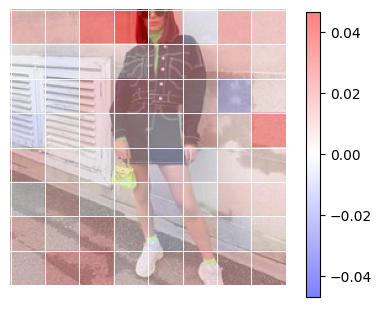

(<Figure size 400x400 with 2 Axes>, <Axes: >)

In [184]:
show_heatmap_with_grid(pil_img, heat, show_colorbar = True)

In [17]:
show_heatmap_with_grid(pil_img, heat, show_colorbar = True, save_path = "D:/figures/3_medium_correct.png")

(<Figure size 400x400 with 2 Axes>, <Axes: >)

In [185]:
tokens, deltas, p_ref_vec, class_idx = text_loo_explain_general(
    pil_img, caption, meta_vec, booster, num_class=3, max_tokens=40
)
print("p_ref:", p_ref_vec, "pred:", class_idx)

p_ref: [0.33968025 0.18232802 0.4779917 ] pred: 2


In [186]:
print("p_ref (P(high)):", p_ref_vec)
print("caption:", caption[:200])
print("p_ref:", p_ref_vec)
print("delta min/max:", deltas.min(), deltas.max())

topk = 10
idx_sorted = np.argsort(-np.abs(deltas))  

for k in range(min(topk, len(tokens))):
    i = idx_sorted[k]
    print(f"{k+1:02d}. token='{tokens[i]}'  delta={deltas[i]:+.4f}")

p_ref (P(high)): [0.33968025 0.18232802 0.4779917 ]
caption: coolest co ord ever see Full outfit babesofmissguided Links buy
p_ref: [0.33968025 0.18232802 0.4779917 ]
delta min/max: -0.032657504 0.001426518
01. token='coolest'  delta=-0.0327
02. token='co'  delta=-0.0225
03. token='ever'  delta=-0.0177
04. token='babesofmissguided'  delta=-0.0140
05. token='buy'  delta=-0.0122
06. token='ord'  delta=-0.0117
07. token='Full'  delta=-0.0113
08. token='Links'  delta=-0.0037
09. token='see'  delta=-0.0025
10. token='outfit'  delta=+0.0014


In [187]:
K = 3
p_ref_vec = predict_proba_from_pil_and_text(pil_img, caption, meta_vec, booster, K)
pred = int(np.argmax(p_ref_vec))

tokens, scores, p_ref_vec2, class_idx = text_span_explain_general(
    pil_img, caption, meta_vec, booster,
    num_class=K, L=5, max_tokens=60
)

print("p_ref (P(high)):", p_ref_vec)
print("caption:", caption[:200])
print("p_ref:", p_ref_vec)
print("score min/max:", scores.min(), scores.max())

topk = 10
idx_sorted = np.argsort(-np.abs(scores)) 

for k in range(min(topk, len(tokens))):
    i = idx_sorted[k]
    print(f"{k+1:02d}. token='{tokens[i]}'  score={scores[i]:+.4f}")


p_ref (P(high)): [0.33968025 0.18232802 0.4779917 ]
caption: coolest co ord ever see Full outfit babesofmissguided Links buy
p_ref: [0.33968025 0.18232802 0.4779917 ]
score min/max: -0.015741005539894104 0.007713288068771362
01. token='co'  score=-0.0157
02. token='ord'  score=-0.0126
03. token='coolest'  score=-0.0116
04. token='ever'  score=-0.0110
05. token='Links'  score=+0.0077
06. token='see'  score=-0.0060
07. token='Full'  score=-0.0034
08. token='babesofmissguided'  score=+0.0031
09. token='buy'  score=+0.0017
10. token='outfit'  score=+0.0007


In [188]:
K = 3
out = modality_ablation_predicted_class(pil_img, caption, meta_vec, booster, K)
print(out)

{'class_idx': 2, 'p_full': 0.4779917001724243, 'p_no_text': 0.4546729028224945, 'delta_text': 0.02331879734992981, 'p_no_img': 0.35487300157546997, 'delta_img': 0.12311869859695435, 'p_no_meta': 0.39963242411613464, 'delta_meta': 0.07835927605628967, 'p_full_vec': array([0.33968025, 0.18232802, 0.4779917 ], dtype=float32)}


In [18]:
# MEDIUM WRONG
idx = 49
row = sample_df.iloc[idx]

pid = row["post_id"]
caption = row["caption"]
img_path = row["img_path_full"]
pil_img = Image.open(img_path).convert("RGB")
meta_vec = row[meta_cols].to_numpy(dtype=np.float32)

p_ref_vec, class_idx, heat = image_occlusion_explain_general(
    caption=caption,
    pil_img=pil_img,
    meta_vec=meta_vec,
    booster=booster,
    num_class=3,
    grid=8,
)
print("p_ref:", p_ref_vec, "pred:", class_idx, "heat min/max:", heat.min(), heat.max())

p_ref: [0.06931993 0.69639295 0.2342871 ] pred: 1 heat min/max: -0.036005497 0.0026143193


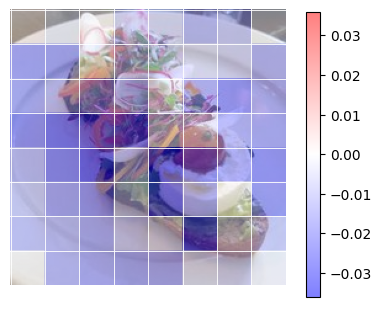

(<Figure size 400x400 with 2 Axes>, <Axes: >)

In [190]:
show_heatmap_with_grid(pil_img, heat, show_colorbar = True)

In [19]:
show_heatmap_with_grid(pil_img, heat, show_colorbar = True, save_path = "D:/figures/3_medium_wrong.png")

(<Figure size 400x400 with 2 Axes>, <Axes: >)

In [191]:
tokens, deltas, p_ref_vec, class_idx = text_loo_explain_general(
    pil_img, caption, meta_vec, booster, num_class=3, max_tokens=40
)
print("p_ref:", p_ref_vec, "pred:", class_idx)

p_ref: [0.06931993 0.69639295 0.2342871 ] pred: 1


In [192]:
print("p_ref (P(high)):", p_ref_vec)
print("caption:", caption[:200])
print("p_ref:", p_ref_vec)
print("delta min/max:", deltas.min(), deltas.max())

topk = 10
idx_sorted = np.argsort(-np.abs(deltas))  

for k in range(min(topk, len(tokens))):
    i = idx_sorted[k]
    print(f"{k+1:02d}. token='{tokens[i]}'  delta={deltas[i]:+.4f}")

p_ref (P(high)): [0.06931993 0.69639295 0.2342871 ]
caption: delicious gorgeous two favorite qualities food burrata avocadotoast business Thank newfave brunch spot eastside gloriaslatincuisine highlandpark hiddengem
p_ref: [0.06931993 0.69639295 0.2342871 ]
delta min/max: -0.025860727 0.024713695
01. token='highlandpark'  delta=-0.0259
02. token='burrata'  delta=+0.0247
03. token='avocadotoast'  delta=-0.0234
04. token='two'  delta=-0.0215
05. token='gloriaslatincuisine'  delta=+0.0138
06. token='newfave'  delta=-0.0119
07. token='eastside'  delta=-0.0117
08. token='hiddengem'  delta=-0.0101
09. token='food'  delta=+0.0096
10. token='gorgeous'  delta=+0.0084


In [193]:
K = 3
p_ref_vec = predict_proba_from_pil_and_text(pil_img, caption, meta_vec, booster, K)
pred = int(np.argmax(p_ref_vec))

tokens, scores, p_ref_vec2, class_idx = text_span_explain_general(
    pil_img, caption, meta_vec, booster,
    num_class=K, L=5, max_tokens=60
)

print("p_ref (P(high)):", p_ref_vec)
print("caption:", caption[:200])
print("p_ref:", p_ref_vec)
print("score min/max:", scores.min(), scores.max())

topk = 10
idx_sorted = np.argsort(-np.abs(scores))  

for k in range(min(topk, len(tokens))):
    i = idx_sorted[k]
    print(f"{k+1:02d}. token='{tokens[i]}'  score={scores[i]:+.4f}")


p_ref (P(high)): [0.06931993 0.69639295 0.2342871 ]
caption: delicious gorgeous two favorite qualities food burrata avocadotoast business Thank newfave brunch spot eastside gloriaslatincuisine highlandpark hiddengem
p_ref: [0.06931993 0.69639295 0.2342871 ]
score min/max: -0.03541345596313476 0.02067992091178894
01. token='avocadotoast'  score=-0.0354
02. token='burrata'  score=-0.0314
03. token='business'  score=-0.0287
04. token='food'  score=-0.0256
05. token='Thank'  score=-0.0234
06. token='highlandpark'  score=+0.0207
07. token='qualities'  score=-0.0205
08. token='gloriaslatincuisine'  score=+0.0190
09. token='hiddengem'  score=+0.0180
10. token='favorite'  score=-0.0167


In [194]:
K = 3
out = modality_ablation_predicted_class(pil_img, caption, meta_vec, booster, K)
print(out)

{'class_idx': 1, 'p_full': 0.6963929533958435, 'p_no_text': 0.697059690952301, 'delta_text': -0.0006667375564575195, 'p_no_img': 0.7730160355567932, 'delta_img': -0.07662308216094971, 'p_no_meta': 0.5479351878166199, 'delta_meta': 0.14845776557922363, 'p_full_vec': array([0.06931993, 0.69639295, 0.2342871 ], dtype=float32)}


# 5 CLASSI

## Define the sample

In [77]:
X_tr = np.load("D:/dataset/multimodal3/X_tr.npy", allow_pickle = True).astype(np.float32)
X_te = np.load("D:/dataset/multimodal3/X_te.npy", allow_pickle = True).astype(np.float32)

y_tr = np.load("D:/dataset/multimodal3/y_tr_5.npy", allow_pickle = True)
y_te = np.load("D:/dataset/multimodal3/y_te_5.npy", allow_pickle = True)

le = LabelEncoder()
y_tr_enc = le.fit_transform(y_tr)
y_te_enc = le.transform(y_te)

for i, cls in enumerate(le.classes_):
    print(i, "->", cls)

0 -> high
1 -> low
2 -> medium
3 -> very_high
4 -> very_low


In [145]:
# Load XGBoost booster
booster = xgb.Booster()
booster.load_model(r"D:/dataset/explainability/xgb_clip_5.json")

In [146]:
# Define the candidate posts with one image

DB_PATH = "D:/db/meta.duckdb"
con = duckdb.connect(DB_PATH)

one_img_df = con.sql("""
WITH one_img AS (
  SELECT
    post_id,
    MIN(full_image_file) AS img_path
  FROM images_manifest1718
  GROUP BY post_id
  HAVING COUNT(*) = 1
)
SELECT
  m.post_id,
  m.caption_bert_clip AS caption,
  m.er_bins AS y_true,
  o.img_path
FROM md1718 m
JOIN one_img o USING (post_id)
WHERE m.split = 'test'
""").df()

one_img_df.head(), one_img_df.shape

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

(                               post_id  \
 0  collinrossfilms-1928431121747229677   
 1  collinrossfilms-1931729185157238739   
 2  collinrossfilms-1937878799686061326   
 3  collinrossfilms-1939584671181332811   
 4  colliveofficial-1941535137632413406   
 
                                              caption     y_true  \
 0                                      Fort Worth TX       high   
 1                                                     very_high   
 2                                                          high   
 3                                                          high   
 4  REBBE NITTEL NACHT Lubavitcher Rebbe Previous ...       high   
 
                                   img_path  
 0  collinrossfilms-1928431121747229677.jpg  
 1  collinrossfilms-1931729185157238739.jpg  
 2  collinrossfilms-1937878799686061326.jpg  
 3  collinrossfilms-1939584671181332811.jpg  
 4  colliveofficial-1941535137632413406.jpg  ,
 (356979, 4))

In [147]:
# Define the sample, with x number of posts per class
sample_df = stratified_sample(one_img_df, "y_true", n_per_class=20, seed=42)
sample_df["y_true"].value_counts(), sample_df.shape

C:\Users\mimox\AppData\Local\Temp\ipykernel_18260\4151775902.py:18: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(min(n_per_class, len(g)), random_state=seed))


(y_true
 high         20
 low          20
 medium       20
 very_high    20
 very_low     20
 Name: count, dtype: int64,
 (100, 4))

In [148]:
# Reconstruct the image path

IMG_ROOT = "D:/dataset/images_224_rgb"
sample_df = sample_df.copy()
sample_df["img_path_full"] = sample_df["img_path"].apply(lambda x: os.path.join(IMG_ROOT, x))
sample_df

,post_id,caption,y_true,img_path,img_path_full
0,thiswildidea-1943773896650394760,Morning walks friend finally got fresh snow ar...,high,thiswildidea-1943773896650394760.jpg,D:/dataset/images_224_rgb\thiswildidea-1943773...
1,stephleamead-1925693883615122996,GIVEAWAY WIN pin letter board either black whi...,high,stephleamead-1925693883615122996.jpg,D:/dataset/images_224_rgb\stephleamead-1925693...
2,eleonoraarico-1938577985197039760,Catchin sunshine black coat visualàporter obje...,high,eleonoraarico-1938577985197039760.jpg,D:/dataset/images_224_rgb\eleonoraarico-193857...
3,byhilaryrose-1937473796711580436,man finally engagement photos blog link bio ha...,high,byhilaryrose-1937473796711580436.jpg,D:/dataset/images_224_rgb\byhilaryrose-1937473...
4,courtneydueppengiesser-1924402598183707197,Details One favorite things document wedding d...,high,courtneydueppengiesser-1924402598183707197.jpg,D:/dataset/images_224_rgb\courtneydueppengiess...
...,...,...,...,...,...
95,mysuburbankitchen-1929855840053153160,cauliflower crust perfect way make pizza wait ...,very_low,mysuburbankitchen-1929855840053153160.jpg,D:/dataset/images_224_rgb\mysuburbankitchen-19...
96,2kidsandacoupon-1934938561276403393,ad HOT Deal alert TODAY get 70 instant savings...,very_low,2kidsandacoupon-1934938561276403393.jpg,D:/dataset/images_224_rgb\2kidsandacoupon-1934...
97,thesooqbh-1936627874582063842,77 770 425 Whats App 973 35942224 973 35912525...,very_low,thesooqbh-1936627874582063842.jpg,D:/dataset/images_224_rgb\thesooqbh-1936627874...
98,prettylifegirls-1938740480730178428,made DIY stitched ornaments sweetest touch lov...,very_low,prettylifegirls-1938740480730178428.jpg,D:/dataset/images_224_rgb\prettylifegirls-1938...


In [149]:
meta_final = pd.read_csv(r"D:/dataset/meta_classification/meta_test_final.csv")
sample_df = sample_df.merge(meta_final, on="post_id", how="left")
# Check there are no missing values
missing = sample_df[sample_df.isna().any(axis=1)]
print("Righe con NaN dopo merge:", len(missing))
missing[["post_id"]].head()

Righe con NaN dopo merge: 0


,post_id


In [150]:
K = 5
p_refs = []

for _, row in sample_df.iterrows():
    meta_vec = row[meta_cols].to_numpy(dtype=np.float32)

    p = predict_proba(
        caption=row["caption"],
        img_path=row["img_path_full"],
        meta_vec=meta_vec,
        booster=booster,
        num_class=K
    )  
    p_refs.append(p)

p_mat = np.vstack(p_refs)  

sample_df = sample_df.copy()
sample_df["p0"] = p_mat[:, 0]
sample_df["p1"] = p_mat[:, 1]
sample_df["p2"] = p_mat[:, 2]
sample_df["p3"] = p_mat[:, 3]
sample_df["p4"] = p_mat[:, 4]

In [153]:
sample_df["y_pred"] = np.argmax(p_mat, axis=1).astype(int)

if np.issubdtype(sample_df["y_true"].dtype, np.number):
    sample_df["y_true_enc"] = sample_df["y_true"].astype(int)

else:
    map_5 = {
        "high": 0,
        "low": 1,
        "medium": 2,
        "very_high": 3,
        "very_low": 4
    }
    sample_df["y_true_enc"] = sample_df["y_true"].map(map_5)

    if sample_df["y_true_enc"].isna().any():
        bad = sample_df.loc[sample_df["y_true_enc"].isna(), "y_true"].unique()
        raise ValueError(f"Unmapped y_true labels: {bad}. Aggiorna map_5.")

    sample_df["y_true_enc"] = sample_df["y_true_enc"].astype(int)

sample_df["correct"] = (sample_df["y_pred"] == sample_df["y_true_enc"])

print(sample_df["correct"].value_counts())
print("sample accuracy:", sample_df["correct"].mean())

inv_map_5 = {0:"high", 1:"low", 2:"medium", 3: "very_high", 4: "very_low"}
sample_df["y_pred_label"] = sample_df["y_pred"].map(inv_map_5)

correct
False    66
True     34
Name: count, dtype: int64
sample accuracy: 0.34


In [155]:
print(sample_df[['p0','p1','p2','p3','p4','y_true','correct','y_pred_label']].to_string(index=True))

          p0        p1        p2        p3        p4     y_true  correct y_pred_label
0   0.288749  0.216683  0.306023  0.094356  0.094189       high    False       medium
1   0.189250  0.101367  0.251774  0.364718  0.092891       high    False    very_high
2   0.185466  0.262922  0.293968  0.090725  0.166920       high    False       medium
3   0.237738  0.252078  0.243848  0.162745  0.103590       high    False          low
4   0.099233  0.291425  0.193263  0.058079  0.358000       high    False     very_low
5   0.072054  0.264229  0.161069  0.052427  0.450221       high    False     very_low
6   0.291596  0.259002  0.274965  0.095973  0.078463       high     True         high
7   0.213301  0.235833  0.261629  0.175180  0.114058       high    False       medium
8   0.109187  0.281785  0.210815  0.054450  0.343763       high    False     very_low
9   0.266623  0.225465  0.256497  0.111381  0.140035       high     True         high
10  0.243738  0.182206  0.243249  0.237761  0.093046  

In [156]:
sample_df.to_csv(
    "D:/dataset/explainability/sample_for_local_explainability_5.csv",
    index=False
)

## Local explanations

In [20]:
sample_df = pd.read_csv("D:/dataset/explainability/sample_for_local_explainability_5.csv")
base_cols = ["post_id", "caption", "img_path", "img_path_full", "y_true", "p0", "p1", "p2", "p3", "p4", "y_true_enc", "y_pred"]

# Select numeric columns
meta_cols = sample_df.drop(columns=base_cols, errors="ignore").select_dtypes(include=[np.number]).columns.tolist()
print("n_meta_cols:", len(meta_cols))
print(meta_cols)
# Load XGBoost booster
booster = xgb.Booster()
booster.load_model(r"D:/dataset/explainability/xgb_clip_5.json")

n_meta_cols: 28
['width', 'height', 'aspect_ratio', 'area', 'dow', 'hour_utc', 'month', 'year', 'caption_len_char', 'n_hashtags', 'n_mentions', 'n_urls', 'n_emojis', 'followees', 'posts', 'has_caption', 'orientation_landscape', 'orientation_portrait', 'orientation_square', 'category_beauty', 'category_family', 'category_fashion', 'category_fitness', 'category_food', 'category_interior', 'category_other', 'category_pet', 'category_travel']


In [21]:
# VH CORRECT
idx = 62
row = sample_df.iloc[idx]

pid = row["post_id"]
caption = row["caption"]
img_path = row["img_path_full"]
pil_img = Image.open(img_path).convert("RGB")
meta_vec = row[meta_cols].to_numpy(dtype=np.float32)

p_ref_vec, class_idx, heat = image_occlusion_explain_general(
    caption=caption,
    pil_img=pil_img,
    meta_vec=meta_vec,
    booster=booster,
    num_class=5,
    grid=8,
)
print("p_ref:", p_ref_vec, "pred:", class_idx, "heat min/max:", heat.min(), heat.max())  

p_ref: [0.2318038  0.09772781 0.14631163 0.47854918 0.04560763] pred: 3 heat min/max: -0.12466192 0.06704426


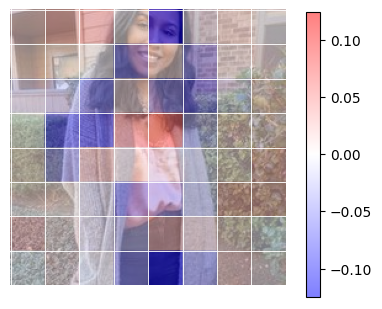

(<Figure size 400x400 with 2 Axes>, <Axes: >)

In [210]:
show_heatmap_with_grid(pil_img, heat, show_colorbar = True)

In [22]:
show_heatmap_with_grid(pil_img, heat, show_colorbar = True, save_path = "D:/figures/5_vh_correct.png")

(<Figure size 400x400 with 2 Axes>, <Axes: >)

In [211]:
tokens, deltas, p_ref_vec, class_idx = text_loo_explain_general(
    pil_img, caption, meta_vec, booster, num_class=5, max_tokens=40
)
print("p_ref:", p_ref_vec, "pred:", class_idx)

p_ref: [0.2318038  0.09772781 0.14631163 0.47854918 0.04560763] pred: 3


In [212]:
print("p_ref (P(high)):", p_ref_vec)
print("caption:", caption[:200])
print("p_ref:", p_ref_vec)
print("delta min/max:", deltas.min(), deltas.max())

topk = 10
idx_sorted = np.argsort(-np.abs(deltas))  

for k in range(min(topk, len(tokens))):
    i = idx_sorted[k]
    print(f"{k+1:02d}. token='{tokens[i]}'  delta={deltas[i]:+.4f}")

p_ref (P(high)): [0.2318038  0.09772781 0.14631163 0.47854918 0.04560763]
caption: newest favorite cardigan wearing everyday listed current favs blog ootd ontheblog f21xme
p_ref: [0.2318038  0.09772781 0.14631163 0.47854918 0.04560763]
delta min/max: -0.01744613 0.03013739
01. token='wearing'  delta=+0.0301
02. token='blog'  delta=+0.0245
03. token='favs'  delta=+0.0245
04. token='current'  delta=+0.0200
05. token='everyday'  delta=-0.0174
06. token='listed'  delta=-0.0105
07. token='ootd'  delta=+0.0091
08. token='ontheblog'  delta=+0.0065
09. token='favorite'  delta=+0.0065
10. token='cardigan'  delta=+0.0037


In [213]:
K = 5
p_ref_vec = predict_proba_from_pil_and_text(pil_img, caption, meta_vec, booster, K)
pred = int(np.argmax(p_ref_vec))

tokens, scores, p_ref_vec2, class_idx = text_span_explain_general(
    pil_img, caption, meta_vec, booster,
    num_class=K, L=5, max_tokens=60
)

print("p_ref (P(high)):", p_ref_vec)
print("caption:", caption[:200])
print("p_ref:", p_ref_vec)
print("score min/max:", scores.min(), scores.max())

topk = 10
idx_sorted = np.argsort(-np.abs(scores))  

for k in range(min(topk, len(tokens))):
    i = idx_sorted[k]
    print(f"{k+1:02d}. token='{tokens[i]}'  score={scores[i]:+.4f}")


p_ref (P(high)): [0.2318038  0.09772781 0.14631163 0.47854918 0.04560763]
caption: newest favorite cardigan wearing everyday listed current favs blog ootd ontheblog f21xme
p_ref: [0.2318038  0.09772781 0.14631163 0.47854918 0.04560763]
score min/max: -0.036180853843688965 0.0150593101978302
01. token='f21xme'  score=-0.0362
02. token='ontheblog'  score=-0.0206
03. token='listed'  score=+0.0151
04. token='newest'  score=-0.0140
05. token='current'  score=+0.0136
06. token='wearing'  score=+0.0114
07. token='everyday'  score=+0.0098
08. token='ootd'  score=-0.0096
09. token='blog'  score=-0.0064
10. token='favorite'  score=-0.0059


In [214]:
K = 5
out = modality_ablation_predicted_class(pil_img, caption, meta_vec, booster, K)
print(out)

{'class_idx': 3, 'p_full': 0.47854918241500854, 'p_no_text': 0.4629477560520172, 'delta_text': 0.015601426362991333, 'p_no_img': 0.31950342655181885, 'delta_img': 0.1590457558631897, 'p_no_meta': 0.10181230306625366, 'delta_meta': 0.3767368793487549, 'p_full_vec': array([0.2318038 , 0.09772781, 0.14631163, 0.47854918, 0.04560763],
      dtype=float32)}


In [23]:
# VH WRONG
idx = 78
row = sample_df.iloc[idx]

pid = row["post_id"]
caption = row["caption"]
img_path = row["img_path_full"]
pil_img = Image.open(img_path).convert("RGB")
meta_vec = row[meta_cols].to_numpy(dtype=np.float32)

p_ref_vec, class_idx, heat = image_occlusion_explain_general(
    caption=caption,
    pil_img=pil_img,
    meta_vec=meta_vec,
    booster=booster,
    num_class=5,
    grid=8,
)
print("p_ref:", p_ref_vec, "pred:", class_idx, "heat min/max:", heat.min(), heat.max())  

p_ref: [0.3448717  0.17378817 0.27267945 0.15364833 0.05501231] pred: 0 heat min/max: -0.01755488 0.034231722


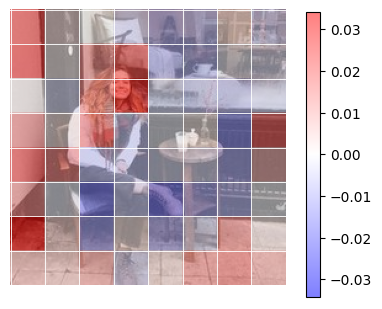

(<Figure size 400x400 with 2 Axes>, <Axes: >)

In [216]:
show_heatmap_with_grid(pil_img, heat, show_colorbar = True)

In [24]:
show_heatmap_with_grid(pil_img, heat, show_colorbar = True, save_path = "D:/figures/5_vh_wrong.png")

(<Figure size 400x400 with 2 Axes>, <Axes: >)

In [217]:
tokens, deltas, p_ref_vec, class_idx = text_loo_explain_general(
    pil_img, caption, meta_vec, booster, num_class=5, max_tokens=40
)
print("p_ref:", p_ref_vec, "pred:", class_idx)

p_ref: [0.3448717  0.17378817 0.27267945 0.15364833 0.05501231] pred: 0


In [218]:
print("p_ref (P(high)):", p_ref_vec)
print("caption:", caption[:200])
print("p_ref:", p_ref_vec)
print("delta min/max:", deltas.min(), deltas.max())

topk = 10
idx_sorted = np.argsort(-np.abs(deltas))  

for k in range(min(topk, len(tokens))):
    i = idx_sorted[k]
    print(f"{k+1:02d}. token='{tokens[i]}'  delta={deltas[i]:+.4f}")

p_ref (P(high)): [0.3448717  0.17378817 0.27267945 0.15364833 0.05501231]
caption: anzeige good mood although cold af maybe also already got early christmas present boots coziest scarf e v e r thäänk youu goertz stylecommunity
p_ref: [0.3448717  0.17378817 0.27267945 0.15364833 0.05501231]
delta min/max: -0.014670789 0.014218092
01. token='scarf'  delta=-0.0147
02. token='boots'  delta=+0.0142
03. token='cold'  delta=+0.0123
04. token='thäänk'  delta=+0.0123
05. token='goertz'  delta=-0.0100
06. token='christmas'  delta=-0.0081
07. token='mood'  delta=+0.0076
08. token='anzeige'  delta=+0.0067
09. token='coziest'  delta=-0.0067
10. token='stylecommunity'  delta=+0.0062


In [219]:
K = 5
p_ref_vec = predict_proba_from_pil_and_text(pil_img, caption, meta_vec, booster, K)
pred = int(np.argmax(p_ref_vec))

tokens, scores, p_ref_vec2, class_idx = text_span_explain_general(
    pil_img, caption, meta_vec, booster,
    num_class=K, L=5, max_tokens=60
)

print("p_ref (P(high)):", p_ref_vec)
print("caption:", caption[:200])
print("p_ref:", p_ref_vec)
print("score min/max:", scores.min(), scores.max())

topk = 10
idx_sorted = np.argsort(-np.abs(scores))  

for k in range(min(topk, len(tokens))):
    i = idx_sorted[k]
    print(f"{k+1:02d}. token='{tokens[i]}'  score={scores[i]:+.4f}")


p_ref (P(high)): [0.3448717  0.17378817 0.27267945 0.15364833 0.05501231]
caption: anzeige good mood although cold af maybe also already got early christmas present boots coziest scarf e v e r thäänk youu goertz stylecommunity
p_ref: [0.3448717  0.17378817 0.27267945 0.15364833 0.05501231]
score min/max: -0.0037501156330108643 0.011564115683237711
01. token='mood'  score=+0.0116
02. token='present'  score=+0.0113
03. token='maybe'  score=+0.0109
04. token='christmas'  score=+0.0107
05. token='af'  score=+0.0104
06. token='early'  score=+0.0102
07. token='cold'  score=+0.0101
08. token='already'  score=+0.0096
09. token='boots'  score=+0.0094
10. token='coziest'  score=+0.0092


In [220]:
K = 5
out = modality_ablation_predicted_class(pil_img, caption, meta_vec, booster, K)
print(out)

{'class_idx': 0, 'p_full': 0.3448716998100281, 'p_no_text': 0.3663717806339264, 'delta_text': -0.021500080823898315, 'p_no_img': 0.203736811876297, 'delta_img': 0.14113488793373108, 'p_no_meta': 0.2769431471824646, 'delta_meta': 0.06792855262756348, 'p_full_vec': array([0.3448717 , 0.17378817, 0.27267945, 0.15364833, 0.05501231],
      dtype=float32)}


In [25]:
# MEDIUM CORRECT
idx = 47
row = sample_df.iloc[idx]

pid = row["post_id"]
caption = row["caption"]
img_path = row["img_path_full"]
pil_img = Image.open(img_path).convert("RGB")
meta_vec = row[meta_cols].to_numpy(dtype=np.float32)

p_ref_vec, class_idx, heat = image_occlusion_explain_general(
    caption=caption,
    pil_img=pil_img,
    meta_vec=meta_vec,
    booster=booster,
    num_class=5,
    grid=8,
)
print("p_ref:", p_ref_vec, "pred:", class_idx, "heat min/max:", heat.min(), heat.max())

p_ref: [0.24720393 0.21200787 0.27062866 0.13049832 0.1396612 ] pred: 2 heat min/max: -0.02608347 0.016007751


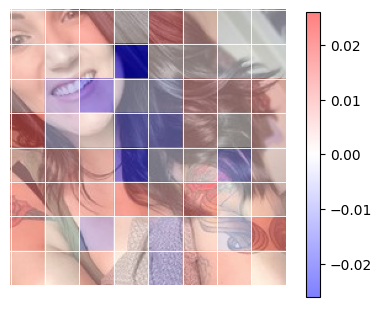

(<Figure size 400x400 with 2 Axes>, <Axes: >)

In [222]:
show_heatmap_with_grid(pil_img, heat, show_colorbar = True)

In [26]:
show_heatmap_with_grid(pil_img, heat, show_colorbar = True, save_path = "D:/figures/5_vl_correct.png")

(<Figure size 400x400 with 2 Axes>, <Axes: >)

In [223]:
tokens, deltas, p_ref_vec, class_idx = text_loo_explain_general(
    pil_img, caption, meta_vec, booster, num_class=5, max_tokens=40
)
print("p_ref:", p_ref_vec, "pred:", class_idx)

p_ref: [0.24720393 0.21200787 0.27062866 0.13049832 0.1396612 ] pred: 2


In [224]:
print("p_ref (P(high)):", p_ref_vec)
print("caption:", caption[:200])
print("p_ref:", p_ref_vec)
print("delta min/max:", deltas.min(), deltas.max())

topk = 10
idx_sorted = np.argsort(-np.abs(deltas))  

for k in range(min(topk, len(tokens))):
    i = idx_sorted[k]
    print(f"{k+1:02d}. token='{tokens[i]}'  delta={deltas[i]:+.4f}")

p_ref (P(high)): [0.24720393 0.21200787 0.27062866 0.13049832 0.1396612 ]
caption: Celebrating pretty important blogging milestones Nov Dec honestly thank every one enough continuing support
p_ref: [0.24720393 0.21200787 0.27062866 0.13049832 0.1396612 ]
delta min/max: -0.0032500923 0.0052684247
01. token='Dec'  delta=+0.0053
02. token='milestones'  delta=+0.0049
03. token='support'  delta=+0.0042
04. token='Nov'  delta=+0.0041
05. token='blogging'  delta=+0.0033
06. token='pretty'  delta=-0.0033
07. token='every'  delta=+0.0029
08. token='continuing'  delta=-0.0018
09. token='thank'  delta=+0.0015
10. token='Celebrating'  delta=-0.0011


In [225]:
K = 5
p_ref_vec = predict_proba_from_pil_and_text(pil_img, caption, meta_vec, booster, K)
pred = int(np.argmax(p_ref_vec))

tokens, scores, p_ref_vec2, class_idx = text_span_explain_general(
    pil_img, caption, meta_vec, booster,
    num_class=K, L=5, max_tokens=60
)

print("p_ref (P(high)):", p_ref_vec)
print("caption:", caption[:200])
print("p_ref:", p_ref_vec)
print("score min/max:", scores.min(), scores.max())

topk = 10
idx_sorted = np.argsort(-np.abs(scores))  

for k in range(min(topk, len(tokens))):
    i = idx_sorted[k]
    print(f"{k+1:02d}. token='{tokens[i]}'  score={scores[i]:+.4f}")


p_ref (P(high)): [0.24720393 0.21200787 0.27062866 0.13049832 0.1396612 ]
caption: Celebrating pretty important blogging milestones Nov Dec honestly thank every one enough continuing support
p_ref: [0.24720393 0.21200787 0.27062866 0.13049832 0.1396612 ]
score min/max: 0.010829973220825195 0.014582216739654541
01. token='support'  score=+0.0146
02. token='pretty'  score=+0.0143
03. token='Celebrating'  score=+0.0140
04. token='milestones'  score=+0.0121
05. token='important'  score=+0.0121
06. token='one'  score=+0.0119
07. token='honestly'  score=+0.0119
08. token='blogging'  score=+0.0118
09. token='enough'  score=+0.0116
10. token='every'  score=+0.0114


In [226]:
K = 5
out = modality_ablation_predicted_class(pil_img, caption, meta_vec, booster, K)
print(out)

{'class_idx': 2, 'p_full': 0.2706286609172821, 'p_no_text': 0.26326265931129456, 'delta_text': 0.007366001605987549, 'p_no_img': 0.18074439465999603, 'delta_img': 0.08988426625728607, 'p_no_meta': 0.2142839878797531, 'delta_meta': 0.05634467303752899, 'p_full_vec': array([0.24720393, 0.21200787, 0.27062866, 0.13049832, 0.1396612 ],
      dtype=float32)}


In [27]:
# VL CORRECT
idx = 97
row = sample_df.iloc[idx]

pid = row["post_id"]
caption = row["caption"]
img_path = row["img_path_full"]
pil_img = Image.open(img_path).convert("RGB")
meta_vec = row[meta_cols].to_numpy(dtype=np.float32)

p_ref_vec, class_idx, heat = image_occlusion_explain_general(
    caption=caption,
    pil_img=pil_img,
    meta_vec=meta_vec,
    booster=booster,
    num_class=5,
    grid=8,
)
print("p_ref:", p_ref_vec, "pred:", class_idx, "heat min/max:", heat.min(), heat.max()) 

p_ref: [0.0275628  0.2456815  0.06371313 0.01182541 0.65121716] pred: 4 heat min/max: -0.053694844 0.032709062


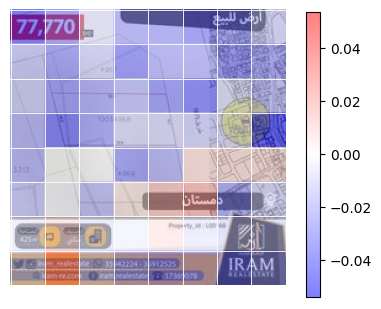

(<Figure size 400x400 with 2 Axes>, <Axes: >)

In [228]:
show_heatmap_with_grid(pil_img, heat, show_colorbar = True)

In [28]:
show_heatmap_with_grid(pil_img, heat, show_colorbar = True, save_path = "D:/figures/5_vl_wrong.png")

(<Figure size 400x400 with 2 Axes>, <Axes: >)

In [229]:
tokens, deltas, p_ref_vec, class_idx = text_loo_explain_general(
    pil_img, caption, meta_vec, booster, num_class=5, max_tokens=40
)
print("p_ref:", p_ref_vec, "pred:", class_idx)

p_ref: [0.0275628  0.2456815  0.06371313 0.01182541 0.65121716] pred: 4


In [230]:
print("p_ref (P(high)):", p_ref_vec)
print("caption:", caption[:200])
print("p_ref:", p_ref_vec)
print("delta min/max:", deltas.min(), deltas.max())

topk = 10
idx_sorted = np.argsort(-np.abs(deltas))  

for k in range(min(topk, len(tokens))):
    i = idx_sorted[k]
    print(f"{k+1:02d}. token='{tokens[i]}'  delta={deltas[i]:+.4f}")

p_ref (P(high)): [0.0275628  0.2456815  0.06371313 0.01182541 0.65121716]
caption: 77 770 425 Whats App 973 35942224 973 35912525 Telephone 973 17369078 Instagram Iram realestate Facebook Iram realestate Twitter Iram realestate Website bahrainrealestate seef juffair gcc amwaj bahrai
p_ref: [0.0275628  0.2456815  0.06371313 0.01182541 0.65121716]
delta min/max: -0.021327198 0.0083755255
01. token='Telephone'  delta=-0.0213
02. token='realestate'  delta=-0.0167
03. token='Iram'  delta=-0.0161
04. token='juffair'  delta=-0.0152
05. token='realestate'  delta=-0.0146
06. token='77'  delta=-0.0131
07. token='Iram'  delta=-0.0128
08. token='Iram'  delta=-0.0127
09. token='properties'  delta=-0.0125
10. token='Whats'  delta=-0.0104


In [231]:
K = 5
p_ref_vec = predict_proba_from_pil_and_text(pil_img, caption, meta_vec, booster, K)
pred = int(np.argmax(p_ref_vec))

tokens, scores, p_ref_vec2, class_idx = text_span_explain_general(
    pil_img, caption, meta_vec, booster,
    num_class=K, L=5, max_tokens=60
)

print("p_ref (P(high)):", p_ref_vec)
print("caption:", caption[:200])
print("p_ref:", p_ref_vec)
print("score min/max:", scores.min(), scores.max())

topk = 10
idx_sorted = np.argsort(-np.abs(scores)) 

for k in range(min(topk, len(tokens))):
    i = idx_sorted[k]
    print(f"{k+1:02d}. token='{tokens[i]}'  score={scores[i]:+.4f}")


p_ref (P(high)): [0.0275628  0.2456815  0.06371313 0.01182541 0.65121716]
caption: 77 770 425 Whats App 973 35942224 973 35912525 Telephone 973 17369078 Instagram Iram realestate Facebook Iram realestate Twitter Iram realestate Website bahrainrealestate seef juffair gcc amwaj bahrai
p_ref: [0.0275628  0.2456815  0.06371313 0.01182541 0.65121716]
score min/max: -0.02139120101928711 -0.0017944574356079102
01. token='realestate'  score=-0.0214
02. token='Iram'  score=-0.0169
03. token='bahraininstagram'  score=-0.0149
04. token='973'  score=-0.0146
05. token='Twitter'  score=-0.0142
06. token='bahraini'  score=-0.0138
07. token='manama'  score=-0.0135
08. token='Iram'  score=-0.0132
09. token='17369078'  score=-0.0127
10. token='bahrainstore'  score=-0.0123


In [232]:
K = 5
out = modality_ablation_predicted_class(pil_img, caption, meta_vec, booster, K)
print(out)

{'class_idx': 4, 'p_full': 0.6512171626091003, 'p_no_text': 0.6466010808944702, 'delta_text': 0.004616081714630127, 'p_no_img': 0.7593091726303101, 'delta_img': -0.10809201002120972, 'p_no_meta': 0.4436343014240265, 'delta_meta': 0.20758286118507385, 'p_full_vec': array([0.0275628 , 0.2456815 , 0.06371313, 0.01182541, 0.65121716],
      dtype=float32)}


In [233]:
# VL WRONG
idx = 87
row = sample_df.iloc[idx]

pid = row["post_id"]
caption = row["caption"]
img_path = row["img_path_full"]
pil_img = Image.open(img_path).convert("RGB")
meta_vec = row[meta_cols].to_numpy(dtype=np.float32)

p_ref_vec, class_idx, heat = image_occlusion_explain_general(
    caption=caption,
    pil_img=pil_img,
    meta_vec=meta_vec,
    booster=booster,
    num_class=5,
    grid=8,
)
print("p_ref:", p_ref_vec, "pred:", class_idx, "heat min/max:", heat.min(), heat.max()) 

p_ref: [0.2288703  0.24636653 0.21881442 0.20254567 0.10340305] pred: 1 heat min/max: -0.03463283 0.014502004


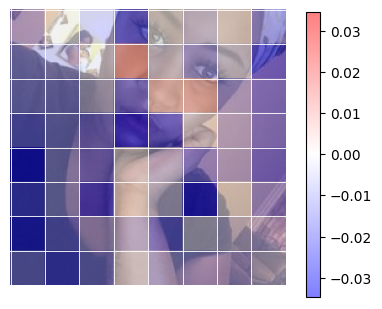

(<Figure size 400x400 with 2 Axes>, <Axes: >)

In [234]:
show_heatmap_with_grid(pil_img, heat, show_colorbar = True)

In [235]:
tokens, deltas, p_ref_vec, class_idx = text_loo_explain_general(
    pil_img, caption, meta_vec, booster, num_class=5, max_tokens=40
)
print("p_ref:", p_ref_vec, "pred:", class_idx)

p_ref: [0.2288703  0.24636653 0.21881442 0.20254567 0.10340305] pred: 1


In [236]:
print("p_ref (P(high)):", p_ref_vec)
print("caption:", caption[:200])
print("p_ref:", p_ref_vec)
print("delta min/max:", deltas.min(), deltas.max())

topk = 10
idx_sorted = np.argsort(-np.abs(deltas))  

for k in range(min(topk, len(tokens))):
    i = idx_sorted[k]
    print(f"{k+1:02d}. token='{tokens[i]}'  delta={deltas[i]:+.4f}")

p_ref (P(high)): [0.2288703  0.24636653 0.21881442 0.20254567 0.10340305]
caption: Monday vibez chillin
p_ref: [0.2288703  0.24636653 0.21881442 0.20254567 0.10340305]
delta min/max: -0.004940599 0.004445553
01. token='vibez'  delta=-0.0049
02. token='chillin'  delta=+0.0044
03. token='Monday'  delta=+0.0009


In [237]:
K = 5
p_ref_vec = predict_proba_from_pil_and_text(pil_img, caption, meta_vec, booster, K)
pred = int(np.argmax(p_ref_vec))

tokens, scores, p_ref_vec2, class_idx = text_span_explain_general(
    pil_img, caption, meta_vec, booster,
    num_class=K, L=5, max_tokens=60
)

print("p_ref (P(high)):", p_ref_vec)
print("caption:", caption[:200])
print("p_ref:", p_ref_vec)
print("score min/max:", scores.min(), scores.max())

topk = 10
idx_sorted = np.argsort(-np.abs(scores))  

for k in range(min(topk, len(tokens))):
    i = idx_sorted[k]
    print(f"{k+1:02d}. token='{tokens[i]}'  score={scores[i]:+.4f}")


p_ref (P(high)): [0.2288703  0.24636653 0.21881442 0.20254567 0.10340305]
caption: Monday vibez chillin
p_ref: [0.2288703  0.24636653 0.21881442 0.20254567 0.10340305]
score min/max: 0.0 0.0
01. token='Monday'  score=+0.0000
02. token='vibez'  score=+0.0000
03. token='chillin'  score=+0.0000


In [238]:
K = 5
out = modality_ablation_predicted_class(pil_img, caption, meta_vec, booster, K)
print(out)

{'class_idx': 1, 'p_full': 0.24636653065681458, 'p_no_text': 0.2593081593513489, 'delta_text': -0.012941628694534302, 'p_no_img': 0.2542687654495239, 'delta_img': -0.00790223479270935, 'p_no_meta': 0.23411212861537933, 'delta_meta': 0.012254402041435242, 'p_full_vec': array([0.2288703 , 0.24636653, 0.21881442, 0.20254567, 0.10340305],
      dtype=float32)}
